<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [VAE2] - First VAE, using a subclass model (MNIST dataset)
<!-- DESC --> Construction and training of a VAE, using model subclass, with a latent space of small dimension.

<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Understanding and implementing a **variational autoencoder** neurals network (VAE)
 - Understanding a still more **advanced programming model**

The calculation needs being important, it is preferable to use a very simple dataset such as MNIST to start with.  
...MNIST with a small scale if you haven't a GPU ;-)

## What we're going to do :

 - Defining a VAE model
 - Build the model
 - Train it
 - Have a look on the train process

## Acknowledgements :
Thanks to **François Chollet** who is at the base of this example (and the creator of Keras !!).  
See : https://keras.io/examples/generative/vae


## Step 1 - Init python stuff

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard

from modules.models    import VAE
from modules.layers    import SamplingLayer
from modules.callbacks import ImagesCallback, BestModelCallback
from modules.datagen   import MNIST

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/VAE2.005'
datasets_dir = pwk.init('VAE2', run_dir)

VAE.about()

**\*\* Overrided parameters : \*\***

run_dir              : ./run/VAE2_done_01


<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.22
Notebook id          : VAE2
Run time             : Monday 22 March 2021, 14:43:08
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run/VAE2_done_01
Update keras cache   : False
Save figs            : True
Path figs            : ./run/VAE2_done_01/figs


<br>**FIDLE 2021 - VAE**

Version              : 1.4
TensorFlow version   : 2.4.0
Keras version        : 2.4.0


## Step 2 - Parameters
`scale` : With scale=1, we need 1'30s on a GPU V100 ...and >20' on a CPU !\
`latent_dim` : 2 dimensions is small, but usefull to draw !


`loss_weights` : Our **loss function** is the weighted sum of two loss:
 - `r_loss` which measures the loss during reconstruction.  
 - `kl_loss` which measures the dispersion.  

The weights are defined by: `loss_weights=[k1,k2]` where : `total_loss = k1*r_loss + k2*kl_loss`  
In practice, a value of \[1,6e-4\] gives good results here.


In [2]:
latent_dim    = 2
loss_weights  = [1,6e-4]

scale         = 1
seed          = 123

batch_size    = 64
epochs        = 10

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('latent_dim', 'loss_weights', 'scale', 'seed', 'batch_size', 'epochs')

**\*\* Overrided parameters : \*\***

latent_dim           : 2
loss_weights         : [1, 0.01]
scale                : 1
seed                 : 123
batch_size           : 64
epochs               : 10


## Step 3 - Prepare data
`MNIST.get_data()` return : `x_train,y_train, x_test,y_test`,  \
but we only need x_train for our training.

Seeded (123)


Dataset loaded.
Concatenated.
Shuffled.
rescaled (1).
Normalized.
Reshaped.
splited (1).


x_train shape is  :  (70000, 28, 28, 1)
x_test  shape is  :  (0, 28, 28, 1)
y_train shape is  :  (70000,)
y_test  shape is  :  (0,)
Blake2b digest is :  0c903710d4d28b01c174


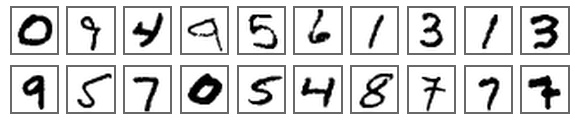

In [4]:
x_data, y_data, _,_ = MNIST.get_data(seed=seed, scale=scale, train_prop=1 )

pwk.plot_images(x_data[:20], None, indices='all', columns=10, x_size=1,y_size=1,y_padding=0, save_as='01-original')

## Step 4 - Build model
In this example, we will use a **custom model**.
For this, we will use :
 - `SamplingLayer`, which generates a vector z from the parameters z_mean and z_log_var - See : [SamplingLayer.py](./modules/layers/SamplingLayer.py)
 - `VAE`, a custom model with a specific train_step - See : [VAE.py](./modules/models/VAE.py)

#### Encoder

In [5]:
inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, strides=1, padding="same", activation="relu")(inputs)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=1, padding="same", activation="relu")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="relu")(x)

z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z         = SamplingLayer()([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.compile()

#### Decoder

In [6]:
inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, strides=1, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
outputs = layers.Conv2DTranspose(1,  3, padding="same", activation="sigmoid")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
decoder.compile()

#### VAE
`VAE` is a custom model with a specific train_step - See : [VAE.py](./modules/models/VAE.py)

In [7]:
vae = VAE(encoder, decoder, loss_weights)

vae.compile(optimizer='adam')

Fidle VAE is ready :-)  loss_weights=[1, 0.01]


## Step 5 - Train
### 5.1 - Using two nice custom callbacks :-)
Two custom callbacks are used:
 - `ImagesCallback` : qui va sauvegarder des images durant l'apprentissage - See [ImagesCallback.py](./modules/callbacks/ImagesCallback.py)
 - `BestModelCallback` : qui sauvegardera le meilleur model - See [BestModelCallback.py](./modules/callbacks/BestModelCallback.py)

In [8]:
callback_images      = ImagesCallback(x=x_data, z_dim=latent_dim, nb_images=5, from_z=True, from_random=True, run_dir=run_dir)
callback_bestmodel   = BestModelCallback( run_dir + '/models/best_model.h5' )
callback_tensorboard = TensorBoard(log_dir=run_dir + '/logs', histogram_freq=1)

callbacks_list = [callback_images, callback_bestmodel]

### 5.2 - Let's train !
With `scale=1`, need 1'15 on a GPU (V100 at IDRIS) ...or 20' on a CPU  

In [9]:
pwk.chrono_start()

history = vae.fit(x_data, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list,)

pwk.chrono_show()

Epoch 1/10


   1/1094 [..............................] - ETA: 1:08:40 - loss: 0.6916 - r_loss: 0.6916 - kl_loss: 2.6986e-06

  12/1094 [..............................] - ETA: 5s - loss: 0.6087 - r_loss: 0.6020 - kl_loss: 0.0067         

  24/1094 [..............................] - ETA: 4s - loss: 0.5207 - r_loss: 0.5172 - kl_loss: 0.0036

  36/1094 [..............................] - ETA: 4s - loss: 0.4602 - r_loss: 0.4577 - kl_loss: 0.0024

  48/1094 [>.............................] - ETA: 4s - loss: 0.4155 - r_loss: 0.4135 - kl_loss: 0.0020

  60/1094 [>.............................] - ETA: 4s - loss: 0.3872 - r_loss: 0.3856 - kl_loss: 0.0016

  72/1094 [>.............................] - ETA: 4s - loss: 0.3680 - r_loss: 0.3666 - kl_loss: 0.0014

  84/1094 [=>............................] - ETA: 4s - loss: 0.3540 - r_loss: 0.3528 - kl_loss: 0.0012

  96/1094 [=>............................] - ETA: 4s - loss: 0.3428 - r_loss: 0.3417 - kl_loss: 0.0010

 108/1094 [=>............................] - ETA: 4s - loss: 0.3344 - r_loss: 0.3335 - kl_loss: 9.3553e-04

 120/1094 [==>...........................] - ETA: 4s - loss: 0.3285 - r_loss: 0.3276 - kl_loss: 8.4446e-04

 132/1094 [==>...........................] - ETA: 4s - loss: 0.3227 - r_loss: 0.3219 - kl_loss: 7.6924e-04

 144/1094 [==>...........................] - ETA: 4s - loss: 0.3180 - r_loss: 0.3173 - kl_loss: 7.0647e-04

 156/1094 [===>..........................] - ETA: 4s - loss: 0.3142 - r_loss: 0.3136 - kl_loss: 6.5407e-04

 168/1094 [===>..........................] - ETA: 4s - loss: 0.3106 - r_loss: 0.3100 - kl_loss: 6.0929e-04

 180/1094 [===>..........................] - ETA: 4s - loss: 0.3079 - r_loss: 0.3073 - kl_loss: 5.7425e-04

 192/1094 [====>.........................] - ETA: 3s - loss: 0.3052 - r_loss: 0.3046 - kl_loss: 5.5773e-04

 204/1094 [====>.........................] - ETA: 3s - loss: 0.3024 - r_loss: 0.3018 - kl_loss: 5.8748e-04

 216/1094 [====>.........................] - ETA: 3s - loss: 0.3002 - r_loss: 0.2995 - kl_loss: 6.6301e-04

 228/1094 [=====>........................] - ETA: 3s - loss: 0.2983 - r_loss: 0.2975 - kl_loss: 7.9333e-04

 240/1094 [=====>........................] - ETA: 3s - loss: 0.2963 - r_loss: 0.2953 - kl_loss: 9.4954e-04

 252/1094 [=====>........................] - ETA: 3s - loss: 0.2944 - r_loss: 0.2933 - kl_loss: 0.0011    

 264/1094 [======>.......................] - ETA: 3s - loss: 0.2926 - r_loss: 0.2914 - kl_loss: 0.0013

 276/1094 [======>.......................] - ETA: 3s - loss: 0.2910 - r_loss: 0.2896 - kl_loss: 0.0014

 288/1094 [======>.......................] - ETA: 3s - loss: 0.2894 - r_loss: 0.2878 - kl_loss: 0.0016

 300/1094 [=======>......................] - ETA: 3s - loss: 0.2880 - r_loss: 0.2863 - kl_loss: 0.0017

 312/1094 [=======>......................] - ETA: 3s - loss: 0.2867 - r_loss: 0.2848 - kl_loss: 0.0019

 324/1094 [=======>......................] - ETA: 3s - loss: 0.2855 - r_loss: 0.2835 - kl_loss: 0.0020

 336/1094 [========>.....................] - ETA: 3s - loss: 0.2844 - r_loss: 0.2822 - kl_loss: 0.0021

 348/1094 [========>.....................] - ETA: 3s - loss: 0.2832 - r_loss: 0.2809 - kl_loss: 0.0022

 360/1094 [========>.....................] - ETA: 3s - loss: 0.2822 - r_loss: 0.2798 - kl_loss: 0.0024

 372/1094 [=========>....................] - ETA: 3s - loss: 0.2812 - r_loss: 0.2787 - kl_loss: 0.0025

 384/1094 [=========>....................] - ETA: 3s - loss: 0.2802 - r_loss: 0.2776 - kl_loss: 0.0026

 396/1094 [=========>....................] - ETA: 3s - loss: 0.2792 - r_loss: 0.2764 - kl_loss: 0.0027

 408/1094 [==========>...................] - ETA: 3s - loss: 0.2783 - r_loss: 0.2755 - kl_loss: 0.0028

 420/1094 [==========>...................] - ETA: 2s - loss: 0.2775 - r_loss: 0.2746 - kl_loss: 0.0029

 432/1094 [==========>...................] - ETA: 2s - loss: 0.2767 - r_loss: 0.2737 - kl_loss: 0.0030

 444/1094 [===========>..................] - ETA: 2s - loss: 0.2760 - r_loss: 0.2729 - kl_loss: 0.0031

 456/1094 [===========>..................] - ETA: 2s - loss: 0.2752 - r_loss: 0.2720 - kl_loss: 0.0032

 468/1094 [===========>..................] - ETA: 2s - loss: 0.2745 - r_loss: 0.2713 - kl_loss: 0.0033

 480/1094 [============>.................] - ETA: 2s - loss: 0.2739 - r_loss: 0.2705 - kl_loss: 0.0034

 492/1094 [============>.................] - ETA: 2s - loss: 0.2733 - r_loss: 0.2698 - kl_loss: 0.0035

 504/1094 [============>.................] - ETA: 2s - loss: 0.2727 - r_loss: 0.2692 - kl_loss: 0.0035

 516/1094 [=============>................] - ETA: 2s - loss: 0.2722 - r_loss: 0.2685 - kl_loss: 0.0036

 528/1094 [=============>................] - ETA: 2s - loss: 0.2716 - r_loss: 0.2679 - kl_loss: 0.0037

 540/1094 [=============>................] - ETA: 2s - loss: 0.2711 - r_loss: 0.2673 - kl_loss: 0.0038

 552/1094 [==============>...............] - ETA: 2s - loss: 0.2704 - r_loss: 0.2666 - kl_loss: 0.0038

 564/1094 [==============>...............] - ETA: 2s - loss: 0.2699 - r_loss: 0.2660 - kl_loss: 0.0039

 576/1094 [==============>...............] - ETA: 2s - loss: 0.2694 - r_loss: 0.2654 - kl_loss: 0.0040

 588/1094 [===============>..............] - ETA: 2s - loss: 0.2688 - r_loss: 0.2648 - kl_loss: 0.0040

 600/1094 [===============>..............] - ETA: 2s - loss: 0.2684 - r_loss: 0.2643 - kl_loss: 0.0041

 612/1094 [===============>..............] - ETA: 2s - loss: 0.2679 - r_loss: 0.2638 - kl_loss: 0.0042

 624/1094 [================>.............] - ETA: 2s - loss: 0.2675 - r_loss: 0.2632 - kl_loss: 0.0042

 636/1094 [================>.............] - ETA: 2s - loss: 0.2671 - r_loss: 0.2628 - kl_loss: 0.0043

 648/1094 [================>.............] - ETA: 1s - loss: 0.2666 - r_loss: 0.2623 - kl_loss: 0.0043

 660/1094 [=================>............] - ETA: 1s - loss: 0.2662 - r_loss: 0.2618 - kl_loss: 0.0044

 672/1094 [=================>............] - ETA: 1s - loss: 0.2658 - r_loss: 0.2613 - kl_loss: 0.0045

 684/1094 [=================>............] - ETA: 1s - loss: 0.2654 - r_loss: 0.2609 - kl_loss: 0.0045

 696/1094 [==================>...........] - ETA: 1s - loss: 0.2651 - r_loss: 0.2605 - kl_loss: 0.0046

 708/1094 [==================>...........] - ETA: 1s - loss: 0.2647 - r_loss: 0.2601 - kl_loss: 0.0046

 720/1094 [==================>...........] - ETA: 1s - loss: 0.2644 - r_loss: 0.2597 - kl_loss: 0.0047

 732/1094 [===================>..........] - ETA: 1s - loss: 0.2641 - r_loss: 0.2594 - kl_loss: 0.0047

 744/1094 [===================>..........] - ETA: 1s - loss: 0.2638 - r_loss: 0.2590 - kl_loss: 0.0048

 756/1094 [===================>..........] - ETA: 1s - loss: 0.2635 - r_loss: 0.2586 - kl_loss: 0.0048

 768/1094 [====================>.........] - ETA: 1s - loss: 0.2631 - r_loss: 0.2582 - kl_loss: 0.0049

 780/1094 [====================>.........] - ETA: 1s - loss: 0.2628 - r_loss: 0.2578 - kl_loss: 0.0049

 792/1094 [====================>.........] - ETA: 1s - loss: 0.2625 - r_loss: 0.2575 - kl_loss: 0.0050

 804/1094 [=====================>........] - ETA: 1s - loss: 0.2622 - r_loss: 0.2572 - kl_loss: 0.0050

 816/1094 [=====================>........] - ETA: 1s - loss: 0.2620 - r_loss: 0.2569 - kl_loss: 0.0051

 828/1094 [=====================>........] - ETA: 1s - loss: 0.2616 - r_loss: 0.2565 - kl_loss: 0.0051

 840/1094 [======================>.......] - ETA: 1s - loss: 0.2613 - r_loss: 0.2561 - kl_loss: 0.0052

 852/1094 [======================>.......] - ETA: 1s - loss: 0.2610 - r_loss: 0.2558 - kl_loss: 0.0052

 864/1094 [======================>.......] - ETA: 1s - loss: 0.2608 - r_loss: 0.2555 - kl_loss: 0.0052

 876/1094 [=======================>......] - ETA: 0s - loss: 0.2606 - r_loss: 0.2553 - kl_loss: 0.0053

 888/1094 [=======================>......] - ETA: 0s - loss: 0.2603 - r_loss: 0.2550 - kl_loss: 0.0053

 900/1094 [=======================>......] - ETA: 0s - loss: 0.2601 - r_loss: 0.2547 - kl_loss: 0.0054

 912/1094 [========================>.....] - ETA: 0s - loss: 0.2599 - r_loss: 0.2545 - kl_loss: 0.0054

 924/1094 [========================>.....] - ETA: 0s - loss: 0.2597 - r_loss: 0.2542 - kl_loss: 0.0055

 936/1094 [========================>.....] - ETA: 0s - loss: 0.2594 - r_loss: 0.2539 - kl_loss: 0.0055

 948/1094 [========================>.....] - ETA: 0s - loss: 0.2592 - r_loss: 0.2537 - kl_loss: 0.0055

 960/1094 [=========================>....] - ETA: 0s - loss: 0.2590 - r_loss: 0.2534 - kl_loss: 0.0056

 972/1094 [=========================>....] - ETA: 0s - loss: 0.2587 - r_loss: 0.2531 - kl_loss: 0.0056

 984/1094 [=========================>....] - ETA: 0s - loss: 0.2585 - r_loss: 0.2529 - kl_loss: 0.0057

 996/1094 [==========================>...] - ETA: 0s - loss: 0.2583 - r_loss: 0.2526 - kl_loss: 0.0057

1008/1094 [==========================>...] - ETA: 0s - loss: 0.2581 - r_loss: 0.2524 - kl_loss: 0.0057

1020/1094 [==========================>...] - ETA: 0s - loss: 0.2579 - r_loss: 0.2521 - kl_loss: 0.0058

1032/1094 [===========================>..] - ETA: 0s - loss: 0.2577 - r_loss: 0.2519 - kl_loss: 0.0058

1044/1094 [===========================>..] - ETA: 0s - loss: 0.2575 - r_loss: 0.2517 - kl_loss: 0.0058

1056/1094 [===========================>..] - ETA: 0s - loss: 0.2573 - r_loss: 0.2514 - kl_loss: 0.0059

1068/1094 [============================>.] - ETA: 0s - loss: 0.2571 - r_loss: 0.2512 - kl_loss: 0.0059

1080/1094 [============================>.] - ETA: 0s - loss: 0.2569 - r_loss: 0.2510 - kl_loss: 0.0059

1092/1094 [============================>.] - ETA: 0s - loss: 0.2567 - r_loss: 0.2508 - kl_loss: 0.0060

1094/1094 [==============================] - ETA: 0s - loss: 0.2567 - r_loss: 0.2507 - kl_loss: 0.0060

1094/1094 [==============================] - 9s 4ms/step - loss: 0.2567 - r_loss: 0.2507 - kl_loss: 0.0060


Epoch 2/10
   1/1094 [..............................] - ETA: 5s - loss: 0.2502 - r_loss: 0.2422 - kl_loss: 0.0079

  13/1094 [..............................] - ETA: 4s - loss: 0.2428 - r_loss: 0.2336 - kl_loss: 0.0091

  25/1094 [..............................] - ETA: 4s - loss: 0.2418 - r_loss: 0.2328 - kl_loss: 0.0090

  37/1094 [>.............................] - ETA: 4s - loss: 0.2418 - r_loss: 0.2326 - kl_loss: 0.0091

  49/1094 [>.............................] - ETA: 4s - loss: 0.2406 - r_loss: 0.2315 - kl_loss: 0.0091

  61/1094 [>.............................] - ETA: 4s - loss: 0.2403 - r_loss: 0.2312 - kl_loss: 0.0092

  73/1094 [=>............................] - ETA: 4s - loss: 0.2402 - r_loss: 0.2310 - kl_loss: 0.0092

  85/1094 [=>............................] - ETA: 4s - loss: 0.2406 - r_loss: 0.2313 - kl_loss: 0.0093

  97/1094 [=>............................] - ETA: 4s - loss: 0.2407 - r_loss: 0.2314 - kl_loss: 0.0093

 109/1094 [=>............................] - ETA: 4s - loss: 0.2410 - r_loss: 0.2317 - kl_loss: 0.0093

 121/1094 [==>...........................] - ETA: 4s - loss: 0.2405 - r_loss: 0.2312 - kl_loss: 0.0092

 133/1094 [==>...........................] - ETA: 4s - loss: 0.2404 - r_loss: 0.2312 - kl_loss: 0.0092

 145/1094 [==>...........................] - ETA: 4s - loss: 0.2404 - r_loss: 0.2311 - kl_loss: 0.0092

 157/1094 [===>..........................] - ETA: 4s - loss: 0.2405 - r_loss: 0.2313 - kl_loss: 0.0092

 169/1094 [===>..........................] - ETA: 4s - loss: 0.2403 - r_loss: 0.2310 - kl_loss: 0.0093

 181/1094 [===>..........................] - ETA: 4s - loss: 0.2405 - r_loss: 0.2313 - kl_loss: 0.0092

 193/1094 [====>.........................] - ETA: 3s - loss: 0.2403 - r_loss: 0.2311 - kl_loss: 0.0093

 205/1094 [====>.........................] - ETA: 3s - loss: 0.2403 - r_loss: 0.2310 - kl_loss: 0.0093

 217/1094 [====>.........................] - ETA: 3s - loss: 0.2402 - r_loss: 0.2309 - kl_loss: 0.0093

 229/1094 [=====>........................] - ETA: 3s - loss: 0.2401 - r_loss: 0.2308 - kl_loss: 0.0093

 241/1094 [=====>........................] - ETA: 3s - loss: 0.2400 - r_loss: 0.2307 - kl_loss: 0.0093

 253/1094 [=====>........................] - ETA: 3s - loss: 0.2396 - r_loss: 0.2303 - kl_loss: 0.0094

 265/1094 [======>.......................] - ETA: 3s - loss: 0.2396 - r_loss: 0.2302 - kl_loss: 0.0094

 277/1094 [======>.......................] - ETA: 3s - loss: 0.2393 - r_loss: 0.2299 - kl_loss: 0.0094

 289/1094 [======>.......................] - ETA: 3s - loss: 0.2394 - r_loss: 0.2299 - kl_loss: 0.0094

 301/1094 [=======>......................] - ETA: 3s - loss: 0.2393 - r_loss: 0.2299 - kl_loss: 0.0094

 313/1094 [=======>......................] - ETA: 3s - loss: 0.2392 - r_loss: 0.2297 - kl_loss: 0.0095

 325/1094 [=======>......................] - ETA: 3s - loss: 0.2392 - r_loss: 0.2298 - kl_loss: 0.0095

 337/1094 [========>.....................] - ETA: 3s - loss: 0.2392 - r_loss: 0.2297 - kl_loss: 0.0095

 349/1094 [========>.....................] - ETA: 3s - loss: 0.2391 - r_loss: 0.2296 - kl_loss: 0.0095

 361/1094 [========>.....................] - ETA: 3s - loss: 0.2391 - r_loss: 0.2296 - kl_loss: 0.0095

 373/1094 [=========>....................] - ETA: 3s - loss: 0.2391 - r_loss: 0.2296 - kl_loss: 0.0095

 385/1094 [=========>....................] - ETA: 3s - loss: 0.2390 - r_loss: 0.2295 - kl_loss: 0.0095

 397/1094 [=========>....................] - ETA: 3s - loss: 0.2389 - r_loss: 0.2294 - kl_loss: 0.0095

 409/1094 [==========>...................] - ETA: 3s - loss: 0.2388 - r_loss: 0.2293 - kl_loss: 0.0096

 421/1094 [==========>...................] - ETA: 2s - loss: 0.2390 - r_loss: 0.2294 - kl_loss: 0.0096

 433/1094 [==========>...................] - ETA: 2s - loss: 0.2389 - r_loss: 0.2293 - kl_loss: 0.0096

 445/1094 [===========>..................] - ETA: 2s - loss: 0.2389 - r_loss: 0.2292 - kl_loss: 0.0096

 457/1094 [===========>..................] - ETA: 2s - loss: 0.2388 - r_loss: 0.2291 - kl_loss: 0.0096

 469/1094 [===========>..................] - ETA: 2s - loss: 0.2387 - r_loss: 0.2290 - kl_loss: 0.0097

 481/1094 [============>.................] - ETA: 2s - loss: 0.2387 - r_loss: 0.2290 - kl_loss: 0.0097

 493/1094 [============>.................] - ETA: 2s - loss: 0.2387 - r_loss: 0.2290 - kl_loss: 0.0097

 505/1094 [============>.................] - ETA: 2s - loss: 0.2386 - r_loss: 0.2289 - kl_loss: 0.0097

 517/1094 [=============>................] - ETA: 2s - loss: 0.2385 - r_loss: 0.2288 - kl_loss: 0.0097

 529/1094 [=============>................] - ETA: 2s - loss: 0.2385 - r_loss: 0.2288 - kl_loss: 0.0097

 541/1094 [=============>................] - ETA: 2s - loss: 0.2385 - r_loss: 0.2288 - kl_loss: 0.0098

 553/1094 [==============>...............] - ETA: 2s - loss: 0.2385 - r_loss: 0.2287 - kl_loss: 0.0098

 565/1094 [==============>...............] - ETA: 2s - loss: 0.2385 - r_loss: 0.2287 - kl_loss: 0.0098

 577/1094 [==============>...............] - ETA: 2s - loss: 0.2384 - r_loss: 0.2286 - kl_loss: 0.0098

 589/1094 [===============>..............] - ETA: 2s - loss: 0.2384 - r_loss: 0.2286 - kl_loss: 0.0098

 601/1094 [===============>..............] - ETA: 2s - loss: 0.2384 - r_loss: 0.2285 - kl_loss: 0.0098

 613/1094 [===============>..............] - ETA: 2s - loss: 0.2382 - r_loss: 0.2284 - kl_loss: 0.0099

 625/1094 [================>.............] - ETA: 2s - loss: 0.2383 - r_loss: 0.2284 - kl_loss: 0.0099

 637/1094 [================>.............] - ETA: 1s - loss: 0.2382 - r_loss: 0.2283 - kl_loss: 0.0099

 649/1094 [================>.............] - ETA: 1s - loss: 0.2381 - r_loss: 0.2282 - kl_loss: 0.0099

 661/1094 [=================>............] - ETA: 1s - loss: 0.2380 - r_loss: 0.2280 - kl_loss: 0.0099

 673/1094 [=================>............] - ETA: 1s - loss: 0.2379 - r_loss: 0.2280 - kl_loss: 0.0099

 685/1094 [=================>............] - ETA: 1s - loss: 0.2379 - r_loss: 0.2279 - kl_loss: 0.0100

 697/1094 [==================>...........] - ETA: 1s - loss: 0.2378 - r_loss: 0.2278 - kl_loss: 0.0100

 709/1094 [==================>...........] - ETA: 1s - loss: 0.2379 - r_loss: 0.2278 - kl_loss: 0.0100

 721/1094 [==================>...........] - ETA: 1s - loss: 0.2378 - r_loss: 0.2278 - kl_loss: 0.0100

 733/1094 [===================>..........] - ETA: 1s - loss: 0.2379 - r_loss: 0.2278 - kl_loss: 0.0100

 745/1094 [===================>..........] - ETA: 1s - loss: 0.2378 - r_loss: 0.2278 - kl_loss: 0.0101

 757/1094 [===================>..........] - ETA: 1s - loss: 0.2378 - r_loss: 0.2277 - kl_loss: 0.0101

 769/1094 [====================>.........] - ETA: 1s - loss: 0.2377 - r_loss: 0.2277 - kl_loss: 0.0101

 781/1094 [====================>.........] - ETA: 1s - loss: 0.2378 - r_loss: 0.2277 - kl_loss: 0.0101

 793/1094 [====================>.........] - ETA: 1s - loss: 0.2377 - r_loss: 0.2276 - kl_loss: 0.0101

 805/1094 [=====================>........] - ETA: 1s - loss: 0.2377 - r_loss: 0.2275 - kl_loss: 0.0101

 817/1094 [=====================>........] - ETA: 1s - loss: 0.2377 - r_loss: 0.2275 - kl_loss: 0.0101

 829/1094 [=====================>........] - ETA: 1s - loss: 0.2376 - r_loss: 0.2275 - kl_loss: 0.0102

 841/1094 [======================>.......] - ETA: 1s - loss: 0.2376 - r_loss: 0.2274 - kl_loss: 0.0102

 853/1094 [======================>.......] - ETA: 1s - loss: 0.2375 - r_loss: 0.2273 - kl_loss: 0.0102

 865/1094 [======================>.......] - ETA: 1s - loss: 0.2375 - r_loss: 0.2272 - kl_loss: 0.0102

 877/1094 [=======================>......] - ETA: 0s - loss: 0.2375 - r_loss: 0.2273 - kl_loss: 0.0102

 889/1094 [=======================>......] - ETA: 0s - loss: 0.2375 - r_loss: 0.2273 - kl_loss: 0.0102

 901/1094 [=======================>......] - ETA: 0s - loss: 0.2374 - r_loss: 0.2272 - kl_loss: 0.0103

 913/1094 [========================>.....] - ETA: 0s - loss: 0.2374 - r_loss: 0.2271 - kl_loss: 0.0103

 925/1094 [========================>.....] - ETA: 0s - loss: 0.2373 - r_loss: 0.2270 - kl_loss: 0.0103

 937/1094 [========================>.....] - ETA: 0s - loss: 0.2373 - r_loss: 0.2270 - kl_loss: 0.0103

 949/1094 [=========================>....] - ETA: 0s - loss: 0.2372 - r_loss: 0.2269 - kl_loss: 0.0103

 961/1094 [=========================>....] - ETA: 0s - loss: 0.2372 - r_loss: 0.2268 - kl_loss: 0.0103

 973/1094 [=========================>....] - ETA: 0s - loss: 0.2371 - r_loss: 0.2268 - kl_loss: 0.0103

 985/1094 [==========================>...] - ETA: 0s - loss: 0.2371 - r_loss: 0.2267 - kl_loss: 0.0104

 997/1094 [==========================>...] - ETA: 0s - loss: 0.2370 - r_loss: 0.2266 - kl_loss: 0.0104

1009/1094 [==========================>...] - ETA: 0s - loss: 0.2370 - r_loss: 0.2266 - kl_loss: 0.0104

1021/1094 [==========================>...] - ETA: 0s - loss: 0.2369 - r_loss: 0.2265 - kl_loss: 0.0104

1033/1094 [===========================>..] - ETA: 0s - loss: 0.2369 - r_loss: 0.2265 - kl_loss: 0.0104

1045/1094 [===========================>..] - ETA: 0s - loss: 0.2369 - r_loss: 0.2265 - kl_loss: 0.0104

1057/1094 [===========================>..] - ETA: 0s - loss: 0.2369 - r_loss: 0.2264 - kl_loss: 0.0104

1069/1094 [============================>.] - ETA: 0s - loss: 0.2368 - r_loss: 0.2264 - kl_loss: 0.0105

1081/1094 [============================>.] - ETA: 0s - loss: 0.2367 - r_loss: 0.2263 - kl_loss: 0.0105

1093/1094 [============================>.] - ETA: 0s - loss: 0.2367 - r_loss: 0.2263 - kl_loss: 0.0105

1094/1094 [==============================] - 5s 4ms/step - loss: 0.2367 - r_loss: 0.2262 - kl_loss: 0.0105


Epoch 3/10
   1/1094 [..............................] - ETA: 5s - loss: 0.2275 - r_loss: 0.2161 - kl_loss: 0.0114

  13/1094 [..............................] - ETA: 4s - loss: 0.2322 - r_loss: 0.2202 - kl_loss: 0.0120

  25/1094 [..............................] - ETA: 4s - loss: 0.2316 - r_loss: 0.2196 - kl_loss: 0.0120

  37/1094 [>.............................] - ETA: 4s - loss: 0.2303 - r_loss: 0.2183 - kl_loss: 0.0120

  49/1094 [>.............................] - ETA: 4s - loss: 0.2305 - r_loss: 0.2185 - kl_loss: 0.0120

  61/1094 [>.............................] - ETA: 4s - loss: 0.2307 - r_loss: 0.2186 - kl_loss: 0.0121

  73/1094 [=>............................] - ETA: 4s - loss: 0.2306 - r_loss: 0.2185 - kl_loss: 0.0121

  85/1094 [=>............................] - ETA: 4s - loss: 0.2311 - r_loss: 0.2191 - kl_loss: 0.0120

  97/1094 [=>............................] - ETA: 4s - loss: 0.2308 - r_loss: 0.2187 - kl_loss: 0.0120

 109/1094 [=>............................] - ETA: 4s - loss: 0.2307 - r_loss: 0.2186 - kl_loss: 0.0121

 121/1094 [==>...........................] - ETA: 4s - loss: 0.2307 - r_loss: 0.2186 - kl_loss: 0.0121

 133/1094 [==>...........................] - ETA: 4s - loss: 0.2308 - r_loss: 0.2187 - kl_loss: 0.0121

 145/1094 [==>...........................] - ETA: 4s - loss: 0.2312 - r_loss: 0.2191 - kl_loss: 0.0121

 157/1094 [===>..........................] - ETA: 4s - loss: 0.2313 - r_loss: 0.2193 - kl_loss: 0.0120

 169/1094 [===>..........................] - ETA: 4s - loss: 0.2315 - r_loss: 0.2195 - kl_loss: 0.0120

 181/1094 [===>..........................] - ETA: 3s - loss: 0.2315 - r_loss: 0.2195 - kl_loss: 0.0120

 193/1094 [====>.........................] - ETA: 3s - loss: 0.2316 - r_loss: 0.2196 - kl_loss: 0.0120

 205/1094 [====>.........................] - ETA: 3s - loss: 0.2316 - r_loss: 0.2196 - kl_loss: 0.0120

 217/1094 [====>.........................] - ETA: 3s - loss: 0.2317 - r_loss: 0.2197 - kl_loss: 0.0120

 229/1094 [=====>........................] - ETA: 3s - loss: 0.2319 - r_loss: 0.2199 - kl_loss: 0.0120

 241/1094 [=====>........................] - ETA: 3s - loss: 0.2319 - r_loss: 0.2198 - kl_loss: 0.0120

 253/1094 [=====>........................] - ETA: 3s - loss: 0.2319 - r_loss: 0.2199 - kl_loss: 0.0120

 265/1094 [======>.......................] - ETA: 3s - loss: 0.2317 - r_loss: 0.2197 - kl_loss: 0.0120

 277/1094 [======>.......................] - ETA: 3s - loss: 0.2316 - r_loss: 0.2195 - kl_loss: 0.0121

 289/1094 [======>.......................] - ETA: 3s - loss: 0.2315 - r_loss: 0.2194 - kl_loss: 0.0121

 301/1094 [=======>......................] - ETA: 3s - loss: 0.2315 - r_loss: 0.2194 - kl_loss: 0.0121

 313/1094 [=======>......................] - ETA: 3s - loss: 0.2315 - r_loss: 0.2195 - kl_loss: 0.0121

 325/1094 [=======>......................] - ETA: 3s - loss: 0.2316 - r_loss: 0.2195 - kl_loss: 0.0121

 337/1094 [========>.....................] - ETA: 3s - loss: 0.2315 - r_loss: 0.2194 - kl_loss: 0.0121

 349/1094 [========>.....................] - ETA: 3s - loss: 0.2316 - r_loss: 0.2195 - kl_loss: 0.0121

 361/1094 [========>.....................] - ETA: 3s - loss: 0.2315 - r_loss: 0.2194 - kl_loss: 0.0121

 373/1094 [=========>....................] - ETA: 3s - loss: 0.2315 - r_loss: 0.2193 - kl_loss: 0.0121

 385/1094 [=========>....................] - ETA: 3s - loss: 0.2315 - r_loss: 0.2193 - kl_loss: 0.0121

 397/1094 [=========>....................] - ETA: 3s - loss: 0.2315 - r_loss: 0.2193 - kl_loss: 0.0121

 409/1094 [==========>...................] - ETA: 2s - loss: 0.2314 - r_loss: 0.2193 - kl_loss: 0.0121

 421/1094 [==========>...................] - ETA: 2s - loss: 0.2314 - r_loss: 0.2193 - kl_loss: 0.0121

 433/1094 [==========>...................] - ETA: 2s - loss: 0.2315 - r_loss: 0.2193 - kl_loss: 0.0122

 445/1094 [===========>..................] - ETA: 2s - loss: 0.2314 - r_loss: 0.2192 - kl_loss: 0.0122

 457/1094 [===========>..................] - ETA: 2s - loss: 0.2314 - r_loss: 0.2193 - kl_loss: 0.0122

 469/1094 [===========>..................] - ETA: 2s - loss: 0.2315 - r_loss: 0.2194 - kl_loss: 0.0122

 481/1094 [============>.................] - ETA: 2s - loss: 0.2316 - r_loss: 0.2195 - kl_loss: 0.0122

 493/1094 [============>.................] - ETA: 2s - loss: 0.2316 - r_loss: 0.2194 - kl_loss: 0.0122

 505/1094 [============>.................] - ETA: 2s - loss: 0.2316 - r_loss: 0.2194 - kl_loss: 0.0122

 517/1094 [=============>................] - ETA: 2s - loss: 0.2316 - r_loss: 0.2194 - kl_loss: 0.0122

 529/1094 [=============>................] - ETA: 2s - loss: 0.2315 - r_loss: 0.2193 - kl_loss: 0.0122

 541/1094 [=============>................] - ETA: 2s - loss: 0.2316 - r_loss: 0.2194 - kl_loss: 0.0122

 553/1094 [==============>...............] - ETA: 2s - loss: 0.2316 - r_loss: 0.2194 - kl_loss: 0.0122

 565/1094 [==============>...............] - ETA: 2s - loss: 0.2315 - r_loss: 0.2193 - kl_loss: 0.0122

 577/1094 [==============>...............] - ETA: 2s - loss: 0.2315 - r_loss: 0.2192 - kl_loss: 0.0122

 589/1094 [===============>..............] - ETA: 2s - loss: 0.2315 - r_loss: 0.2193 - kl_loss: 0.0122

 601/1094 [===============>..............] - ETA: 2s - loss: 0.2315 - r_loss: 0.2192 - kl_loss: 0.0122

 613/1094 [===============>..............] - ETA: 2s - loss: 0.2314 - r_loss: 0.2192 - kl_loss: 0.0122

 625/1094 [================>.............] - ETA: 2s - loss: 0.2314 - r_loss: 0.2192 - kl_loss: 0.0122

 637/1094 [================>.............] - ETA: 1s - loss: 0.2314 - r_loss: 0.2191 - kl_loss: 0.0122

 649/1094 [================>.............] - ETA: 1s - loss: 0.2314 - r_loss: 0.2192 - kl_loss: 0.0122

 661/1094 [=================>............] - ETA: 1s - loss: 0.2314 - r_loss: 0.2191 - kl_loss: 0.0122

 673/1094 [=================>............] - ETA: 1s - loss: 0.2314 - r_loss: 0.2191 - kl_loss: 0.0122

 685/1094 [=================>............] - ETA: 1s - loss: 0.2314 - r_loss: 0.2191 - kl_loss: 0.0123

 697/1094 [==================>...........] - ETA: 1s - loss: 0.2313 - r_loss: 0.2190 - kl_loss: 0.0123

 709/1094 [==================>...........] - ETA: 1s - loss: 0.2313 - r_loss: 0.2190 - kl_loss: 0.0123

 721/1094 [==================>...........] - ETA: 1s - loss: 0.2312 - r_loss: 0.2189 - kl_loss: 0.0123

 733/1094 [===================>..........] - ETA: 1s - loss: 0.2311 - r_loss: 0.2189 - kl_loss: 0.0123

 745/1094 [===================>..........] - ETA: 1s - loss: 0.2312 - r_loss: 0.2189 - kl_loss: 0.0123

 757/1094 [===================>..........] - ETA: 1s - loss: 0.2312 - r_loss: 0.2189 - kl_loss: 0.0123

 769/1094 [====================>.........] - ETA: 1s - loss: 0.2311 - r_loss: 0.2189 - kl_loss: 0.0123

 781/1094 [====================>.........] - ETA: 1s - loss: 0.2312 - r_loss: 0.2189 - kl_loss: 0.0123

 793/1094 [====================>.........] - ETA: 1s - loss: 0.2312 - r_loss: 0.2189 - kl_loss: 0.0123

 805/1094 [=====================>........] - ETA: 1s - loss: 0.2312 - r_loss: 0.2188 - kl_loss: 0.0123

 817/1094 [=====================>........] - ETA: 1s - loss: 0.2312 - r_loss: 0.2188 - kl_loss: 0.0123

 829/1094 [=====================>........] - ETA: 1s - loss: 0.2311 - r_loss: 0.2188 - kl_loss: 0.0123

 841/1094 [======================>.......] - ETA: 1s - loss: 0.2311 - r_loss: 0.2188 - kl_loss: 0.0123

 853/1094 [======================>.......] - ETA: 1s - loss: 0.2311 - r_loss: 0.2187 - kl_loss: 0.0123

 865/1094 [======================>.......] - ETA: 0s - loss: 0.2310 - r_loss: 0.2187 - kl_loss: 0.0123

 877/1094 [=======================>......] - ETA: 0s - loss: 0.2311 - r_loss: 0.2188 - kl_loss: 0.0123

 889/1094 [=======================>......] - ETA: 0s - loss: 0.2312 - r_loss: 0.2188 - kl_loss: 0.0123

 901/1094 [=======================>......] - ETA: 0s - loss: 0.2312 - r_loss: 0.2188 - kl_loss: 0.0123

 913/1094 [========================>.....] - ETA: 0s - loss: 0.2312 - r_loss: 0.2189 - kl_loss: 0.0124

 925/1094 [========================>.....] - ETA: 0s - loss: 0.2312 - r_loss: 0.2189 - kl_loss: 0.0124

 937/1094 [========================>.....] - ETA: 0s - loss: 0.2312 - r_loss: 0.2189 - kl_loss: 0.0124

 949/1094 [=========================>....] - ETA: 0s - loss: 0.2311 - r_loss: 0.2188 - kl_loss: 0.0124

 961/1094 [=========================>....] - ETA: 0s - loss: 0.2311 - r_loss: 0.2187 - kl_loss: 0.0124

 973/1094 [=========================>....] - ETA: 0s - loss: 0.2311 - r_loss: 0.2187 - kl_loss: 0.0124

 985/1094 [==========================>...] - ETA: 0s - loss: 0.2310 - r_loss: 0.2187 - kl_loss: 0.0124

 997/1094 [==========================>...] - ETA: 0s - loss: 0.2310 - r_loss: 0.2186 - kl_loss: 0.0124

1009/1094 [==========================>...] - ETA: 0s - loss: 0.2309 - r_loss: 0.2185 - kl_loss: 0.0124

1021/1094 [==========================>...] - ETA: 0s - loss: 0.2309 - r_loss: 0.2185 - kl_loss: 0.0124

1033/1094 [===========================>..] - ETA: 0s - loss: 0.2309 - r_loss: 0.2185 - kl_loss: 0.0124

1045/1094 [===========================>..] - ETA: 0s - loss: 0.2309 - r_loss: 0.2185 - kl_loss: 0.0124

1057/1094 [===========================>..] - ETA: 0s - loss: 0.2309 - r_loss: 0.2185 - kl_loss: 0.0124

1069/1094 [============================>.] - ETA: 0s - loss: 0.2309 - r_loss: 0.2185 - kl_loss: 0.0124

1081/1094 [============================>.] - ETA: 0s - loss: 0.2310 - r_loss: 0.2185 - kl_loss: 0.0124

1093/1094 [============================>.] - ETA: 0s - loss: 0.2310 - r_loss: 0.2186 - kl_loss: 0.0124

1094/1094 [==============================] - 5s 4ms/step - loss: 0.2310 - r_loss: 0.2185 - kl_loss: 0.0124


Epoch 4/10
   1/1094 [..............................] - ETA: 5s - loss: 0.2225 - r_loss: 0.2100 - kl_loss: 0.0125

  13/1094 [..............................] - ETA: 4s - loss: 0.2303 - r_loss: 0.2173 - kl_loss: 0.0130

  25/1094 [..............................] - ETA: 4s - loss: 0.2287 - r_loss: 0.2157 - kl_loss: 0.0131

  37/1094 [>.............................] - ETA: 4s - loss: 0.2276 - r_loss: 0.2147 - kl_loss: 0.0129

  49/1094 [>.............................] - ETA: 4s - loss: 0.2275 - r_loss: 0.2146 - kl_loss: 0.0129

  61/1094 [>.............................] - ETA: 4s - loss: 0.2274 - r_loss: 0.2144 - kl_loss: 0.0130

  73/1094 [=>............................] - ETA: 4s - loss: 0.2279 - r_loss: 0.2149 - kl_loss: 0.0130

  85/1094 [=>............................] - ETA: 4s - loss: 0.2278 - r_loss: 0.2147 - kl_loss: 0.0131

  97/1094 [=>............................] - ETA: 4s - loss: 0.2277 - r_loss: 0.2147 - kl_loss: 0.0130

 109/1094 [=>............................] - ETA: 4s - loss: 0.2280 - r_loss: 0.2150 - kl_loss: 0.0130

 121/1094 [==>...........................] - ETA: 4s - loss: 0.2284 - r_loss: 0.2154 - kl_loss: 0.0130

 133/1094 [==>...........................] - ETA: 4s - loss: 0.2284 - r_loss: 0.2154 - kl_loss: 0.0130

 145/1094 [==>...........................] - ETA: 4s - loss: 0.2285 - r_loss: 0.2155 - kl_loss: 0.0131

 157/1094 [===>..........................] - ETA: 4s - loss: 0.2285 - r_loss: 0.2154 - kl_loss: 0.0131

 169/1094 [===>..........................] - ETA: 4s - loss: 0.2284 - r_loss: 0.2154 - kl_loss: 0.0131

 181/1094 [===>..........................] - ETA: 3s - loss: 0.2281 - r_loss: 0.2151 - kl_loss: 0.0131

 193/1094 [====>.........................] - ETA: 3s - loss: 0.2285 - r_loss: 0.2154 - kl_loss: 0.0130

 205/1094 [====>.........................] - ETA: 3s - loss: 0.2286 - r_loss: 0.2156 - kl_loss: 0.0130

 217/1094 [====>.........................] - ETA: 3s - loss: 0.2285 - r_loss: 0.2155 - kl_loss: 0.0130

 229/1094 [=====>........................] - ETA: 3s - loss: 0.2285 - r_loss: 0.2155 - kl_loss: 0.0130

 241/1094 [=====>........................] - ETA: 3s - loss: 0.2286 - r_loss: 0.2156 - kl_loss: 0.0130

 253/1094 [=====>........................] - ETA: 3s - loss: 0.2286 - r_loss: 0.2156 - kl_loss: 0.0130

 265/1094 [======>.......................] - ETA: 3s - loss: 0.2285 - r_loss: 0.2155 - kl_loss: 0.0130

 277/1094 [======>.......................] - ETA: 3s - loss: 0.2284 - r_loss: 0.2153 - kl_loss: 0.0130

 289/1094 [======>.......................] - ETA: 3s - loss: 0.2283 - r_loss: 0.2153 - kl_loss: 0.0130

 301/1094 [=======>......................] - ETA: 3s - loss: 0.2286 - r_loss: 0.2155 - kl_loss: 0.0130

 313/1094 [=======>......................] - ETA: 3s - loss: 0.2287 - r_loss: 0.2157 - kl_loss: 0.0130

 325/1094 [=======>......................] - ETA: 3s - loss: 0.2286 - r_loss: 0.2156 - kl_loss: 0.0131

 337/1094 [========>.....................] - ETA: 3s - loss: 0.2287 - r_loss: 0.2156 - kl_loss: 0.0131

 349/1094 [========>.....................] - ETA: 3s - loss: 0.2288 - r_loss: 0.2157 - kl_loss: 0.0131

 361/1094 [========>.....................] - ETA: 3s - loss: 0.2288 - r_loss: 0.2158 - kl_loss: 0.0131

 373/1094 [=========>....................] - ETA: 3s - loss: 0.2290 - r_loss: 0.2159 - kl_loss: 0.0130

 385/1094 [=========>....................] - ETA: 3s - loss: 0.2290 - r_loss: 0.2159 - kl_loss: 0.0131

 397/1094 [=========>....................] - ETA: 3s - loss: 0.2289 - r_loss: 0.2158 - kl_loss: 0.0131

 409/1094 [==========>...................] - ETA: 2s - loss: 0.2289 - r_loss: 0.2159 - kl_loss: 0.0131

 421/1094 [==========>...................] - ETA: 2s - loss: 0.2289 - r_loss: 0.2158 - kl_loss: 0.0131

 433/1094 [==========>...................] - ETA: 2s - loss: 0.2289 - r_loss: 0.2158 - kl_loss: 0.0131

 445/1094 [===========>..................] - ETA: 2s - loss: 0.2288 - r_loss: 0.2157 - kl_loss: 0.0131

 457/1094 [===========>..................] - ETA: 2s - loss: 0.2287 - r_loss: 0.2156 - kl_loss: 0.0131

 469/1094 [===========>..................] - ETA: 2s - loss: 0.2286 - r_loss: 0.2155 - kl_loss: 0.0131

 481/1094 [============>.................] - ETA: 2s - loss: 0.2287 - r_loss: 0.2156 - kl_loss: 0.0131

 493/1094 [============>.................] - ETA: 2s - loss: 0.2287 - r_loss: 0.2155 - kl_loss: 0.0131

 505/1094 [============>.................] - ETA: 2s - loss: 0.2287 - r_loss: 0.2156 - kl_loss: 0.0131

 517/1094 [=============>................] - ETA: 2s - loss: 0.2288 - r_loss: 0.2157 - kl_loss: 0.0131

 529/1094 [=============>................] - ETA: 2s - loss: 0.2288 - r_loss: 0.2156 - kl_loss: 0.0131

 541/1094 [=============>................] - ETA: 2s - loss: 0.2289 - r_loss: 0.2157 - kl_loss: 0.0131

 553/1094 [==============>...............] - ETA: 2s - loss: 0.2288 - r_loss: 0.2157 - kl_loss: 0.0131

 565/1094 [==============>...............] - ETA: 2s - loss: 0.2288 - r_loss: 0.2157 - kl_loss: 0.0131

 577/1094 [==============>...............] - ETA: 2s - loss: 0.2288 - r_loss: 0.2156 - kl_loss: 0.0131

 589/1094 [===============>..............] - ETA: 2s - loss: 0.2287 - r_loss: 0.2156 - kl_loss: 0.0131

 601/1094 [===============>..............] - ETA: 2s - loss: 0.2287 - r_loss: 0.2156 - kl_loss: 0.0131

 613/1094 [===============>..............] - ETA: 2s - loss: 0.2288 - r_loss: 0.2157 - kl_loss: 0.0131

 625/1094 [================>.............] - ETA: 2s - loss: 0.2288 - r_loss: 0.2156 - kl_loss: 0.0131

 637/1094 [================>.............] - ETA: 1s - loss: 0.2288 - r_loss: 0.2157 - kl_loss: 0.0132

 649/1094 [================>.............] - ETA: 1s - loss: 0.2288 - r_loss: 0.2156 - kl_loss: 0.0132

 661/1094 [=================>............] - ETA: 1s - loss: 0.2288 - r_loss: 0.2157 - kl_loss: 0.0132

 673/1094 [=================>............] - ETA: 1s - loss: 0.2288 - r_loss: 0.2156 - kl_loss: 0.0132

 685/1094 [=================>............] - ETA: 1s - loss: 0.2287 - r_loss: 0.2156 - kl_loss: 0.0132

 697/1094 [==================>...........] - ETA: 1s - loss: 0.2287 - r_loss: 0.2155 - kl_loss: 0.0132

 709/1094 [==================>...........] - ETA: 1s - loss: 0.2286 - r_loss: 0.2155 - kl_loss: 0.0132

 721/1094 [==================>...........] - ETA: 1s - loss: 0.2286 - r_loss: 0.2155 - kl_loss: 0.0132

 733/1094 [===================>..........] - ETA: 1s - loss: 0.2286 - r_loss: 0.2154 - kl_loss: 0.0132

 745/1094 [===================>..........] - ETA: 1s - loss: 0.2286 - r_loss: 0.2154 - kl_loss: 0.0132

 757/1094 [===================>..........] - ETA: 1s - loss: 0.2286 - r_loss: 0.2154 - kl_loss: 0.0132

 769/1094 [====================>.........] - ETA: 1s - loss: 0.2286 - r_loss: 0.2154 - kl_loss: 0.0132

 781/1094 [====================>.........] - ETA: 1s - loss: 0.2286 - r_loss: 0.2154 - kl_loss: 0.0132

 793/1094 [====================>.........] - ETA: 1s - loss: 0.2286 - r_loss: 0.2154 - kl_loss: 0.0132

 805/1094 [=====================>........] - ETA: 1s - loss: 0.2286 - r_loss: 0.2154 - kl_loss: 0.0132

 817/1094 [=====================>........] - ETA: 1s - loss: 0.2286 - r_loss: 0.2154 - kl_loss: 0.0132

 829/1094 [=====================>........] - ETA: 1s - loss: 0.2285 - r_loss: 0.2153 - kl_loss: 0.0132

 841/1094 [======================>.......] - ETA: 1s - loss: 0.2285 - r_loss: 0.2153 - kl_loss: 0.0132

 853/1094 [======================>.......] - ETA: 1s - loss: 0.2286 - r_loss: 0.2154 - kl_loss: 0.0132

 865/1094 [======================>.......] - ETA: 1s - loss: 0.2286 - r_loss: 0.2154 - kl_loss: 0.0132

 877/1094 [=======================>......] - ETA: 0s - loss: 0.2286 - r_loss: 0.2154 - kl_loss: 0.0132

 889/1094 [=======================>......] - ETA: 0s - loss: 0.2285 - r_loss: 0.2153 - kl_loss: 0.0132

 901/1094 [=======================>......] - ETA: 0s - loss: 0.2285 - r_loss: 0.2153 - kl_loss: 0.0132

 913/1094 [========================>.....] - ETA: 0s - loss: 0.2284 - r_loss: 0.2152 - kl_loss: 0.0132

 925/1094 [========================>.....] - ETA: 0s - loss: 0.2285 - r_loss: 0.2153 - kl_loss: 0.0132

 937/1094 [========================>.....] - ETA: 0s - loss: 0.2285 - r_loss: 0.2153 - kl_loss: 0.0132

 949/1094 [=========================>....] - ETA: 0s - loss: 0.2286 - r_loss: 0.2154 - kl_loss: 0.0132

 961/1094 [=========================>....] - ETA: 0s - loss: 0.2286 - r_loss: 0.2154 - kl_loss: 0.0132

 973/1094 [=========================>....] - ETA: 0s - loss: 0.2286 - r_loss: 0.2154 - kl_loss: 0.0132

 985/1094 [==========================>...] - ETA: 0s - loss: 0.2285 - r_loss: 0.2153 - kl_loss: 0.0132

 997/1094 [==========================>...] - ETA: 0s - loss: 0.2285 - r_loss: 0.2153 - kl_loss: 0.0132

1009/1094 [==========================>...] - ETA: 0s - loss: 0.2285 - r_loss: 0.2152 - kl_loss: 0.0132

1019/1094 [==========================>...] - ETA: 0s - loss: 0.2284 - r_loss: 0.2152 - kl_loss: 0.0132

1031/1094 [===========================>..] - ETA: 0s - loss: 0.2284 - r_loss: 0.2152 - kl_loss: 0.0132

1043/1094 [===========================>..] - ETA: 0s - loss: 0.2284 - r_loss: 0.2152 - kl_loss: 0.0132

1055/1094 [===========================>..] - ETA: 0s - loss: 0.2284 - r_loss: 0.2151 - kl_loss: 0.0132

1067/1094 [============================>.] - ETA: 0s - loss: 0.2283 - r_loss: 0.2151 - kl_loss: 0.0132

1079/1094 [============================>.] - ETA: 0s - loss: 0.2283 - r_loss: 0.2150 - kl_loss: 0.0132

1091/1094 [============================>.] - ETA: 0s - loss: 0.2282 - r_loss: 0.2150 - kl_loss: 0.0132

1094/1094 [==============================] - 5s 4ms/step - loss: 0.2282 - r_loss: 0.2150 - kl_loss: 0.0132


Epoch 5/10
   1/1094 [..............................] - ETA: 5s - loss: 0.2186 - r_loss: 0.2047 - kl_loss: 0.0140

  13/1094 [..............................] - ETA: 4s - loss: 0.2243 - r_loss: 0.2111 - kl_loss: 0.0132

  25/1094 [..............................] - ETA: 4s - loss: 0.2244 - r_loss: 0.2110 - kl_loss: 0.0134

  37/1094 [>.............................] - ETA: 4s - loss: 0.2246 - r_loss: 0.2110 - kl_loss: 0.0136

  49/1094 [>.............................] - ETA: 4s - loss: 0.2250 - r_loss: 0.2113 - kl_loss: 0.0136

  61/1094 [>.............................] - ETA: 4s - loss: 0.2264 - r_loss: 0.2127 - kl_loss: 0.0136

  73/1094 [=>............................] - ETA: 4s - loss: 0.2270 - r_loss: 0.2134 - kl_loss: 0.0136

  85/1094 [=>............................] - ETA: 4s - loss: 0.2275 - r_loss: 0.2139 - kl_loss: 0.0135

  97/1094 [=>............................] - ETA: 4s - loss: 0.2276 - r_loss: 0.2141 - kl_loss: 0.0135

 109/1094 [=>............................] - ETA: 4s - loss: 0.2271 - r_loss: 0.2136 - kl_loss: 0.0135

 121/1094 [==>...........................] - ETA: 4s - loss: 0.2271 - r_loss: 0.2136 - kl_loss: 0.0135

 133/1094 [==>...........................] - ETA: 4s - loss: 0.2270 - r_loss: 0.2135 - kl_loss: 0.0135

 145/1094 [==>...........................] - ETA: 4s - loss: 0.2274 - r_loss: 0.2139 - kl_loss: 0.0135

 157/1094 [===>..........................] - ETA: 4s - loss: 0.2272 - r_loss: 0.2137 - kl_loss: 0.0135

 169/1094 [===>..........................] - ETA: 4s - loss: 0.2272 - r_loss: 0.2137 - kl_loss: 0.0136

 181/1094 [===>..........................] - ETA: 4s - loss: 0.2271 - r_loss: 0.2135 - kl_loss: 0.0136

 193/1094 [====>.........................] - ETA: 3s - loss: 0.2270 - r_loss: 0.2134 - kl_loss: 0.0136

 205/1094 [====>.........................] - ETA: 3s - loss: 0.2270 - r_loss: 0.2134 - kl_loss: 0.0136

 217/1094 [====>.........................] - ETA: 3s - loss: 0.2269 - r_loss: 0.2134 - kl_loss: 0.0136

 229/1094 [=====>........................] - ETA: 3s - loss: 0.2269 - r_loss: 0.2133 - kl_loss: 0.0136

 241/1094 [=====>........................] - ETA: 3s - loss: 0.2267 - r_loss: 0.2131 - kl_loss: 0.0136

 253/1094 [=====>........................] - ETA: 3s - loss: 0.2267 - r_loss: 0.2130 - kl_loss: 0.0136

 265/1094 [======>.......................] - ETA: 3s - loss: 0.2267 - r_loss: 0.2131 - kl_loss: 0.0136

 277/1094 [======>.......................] - ETA: 3s - loss: 0.2267 - r_loss: 0.2130 - kl_loss: 0.0136

 289/1094 [======>.......................] - ETA: 3s - loss: 0.2268 - r_loss: 0.2132 - kl_loss: 0.0136

 301/1094 [=======>......................] - ETA: 3s - loss: 0.2267 - r_loss: 0.2130 - kl_loss: 0.0136

 313/1094 [=======>......................] - ETA: 3s - loss: 0.2267 - r_loss: 0.2130 - kl_loss: 0.0136

 325/1094 [=======>......................] - ETA: 3s - loss: 0.2267 - r_loss: 0.2131 - kl_loss: 0.0136

 337/1094 [========>.....................] - ETA: 3s - loss: 0.2266 - r_loss: 0.2130 - kl_loss: 0.0136

 349/1094 [========>.....................] - ETA: 3s - loss: 0.2265 - r_loss: 0.2129 - kl_loss: 0.0136

 361/1094 [========>.....................] - ETA: 3s - loss: 0.2266 - r_loss: 0.2130 - kl_loss: 0.0136

 373/1094 [=========>....................] - ETA: 3s - loss: 0.2267 - r_loss: 0.2131 - kl_loss: 0.0136

 385/1094 [=========>....................] - ETA: 3s - loss: 0.2266 - r_loss: 0.2130 - kl_loss: 0.0136

 397/1094 [=========>....................] - ETA: 3s - loss: 0.2267 - r_loss: 0.2130 - kl_loss: 0.0136

 409/1094 [==========>...................] - ETA: 3s - loss: 0.2267 - r_loss: 0.2130 - kl_loss: 0.0136

 421/1094 [==========>...................] - ETA: 2s - loss: 0.2267 - r_loss: 0.2131 - kl_loss: 0.0136

 433/1094 [==========>...................] - ETA: 2s - loss: 0.2268 - r_loss: 0.2132 - kl_loss: 0.0136

 445/1094 [===========>..................] - ETA: 2s - loss: 0.2268 - r_loss: 0.2131 - kl_loss: 0.0136

 457/1094 [===========>..................] - ETA: 2s - loss: 0.2268 - r_loss: 0.2131 - kl_loss: 0.0137

 469/1094 [===========>..................] - ETA: 2s - loss: 0.2268 - r_loss: 0.2131 - kl_loss: 0.0137

 481/1094 [============>.................] - ETA: 2s - loss: 0.2269 - r_loss: 0.2133 - kl_loss: 0.0136

 493/1094 [============>.................] - ETA: 2s - loss: 0.2269 - r_loss: 0.2132 - kl_loss: 0.0136

 505/1094 [============>.................] - ETA: 2s - loss: 0.2268 - r_loss: 0.2131 - kl_loss: 0.0136

 517/1094 [=============>................] - ETA: 2s - loss: 0.2268 - r_loss: 0.2131 - kl_loss: 0.0137

 529/1094 [=============>................] - ETA: 2s - loss: 0.2269 - r_loss: 0.2132 - kl_loss: 0.0137

 541/1094 [=============>................] - ETA: 2s - loss: 0.2269 - r_loss: 0.2133 - kl_loss: 0.0137

 553/1094 [==============>...............] - ETA: 2s - loss: 0.2271 - r_loss: 0.2134 - kl_loss: 0.0136

 565/1094 [==============>...............] - ETA: 2s - loss: 0.2270 - r_loss: 0.2134 - kl_loss: 0.0136

 577/1094 [==============>...............] - ETA: 2s - loss: 0.2270 - r_loss: 0.2134 - kl_loss: 0.0136

 589/1094 [===============>..............] - ETA: 2s - loss: 0.2271 - r_loss: 0.2135 - kl_loss: 0.0136

 601/1094 [===============>..............] - ETA: 2s - loss: 0.2271 - r_loss: 0.2135 - kl_loss: 0.0136

 613/1094 [===============>..............] - ETA: 2s - loss: 0.2271 - r_loss: 0.2135 - kl_loss: 0.0136

 625/1094 [================>.............] - ETA: 2s - loss: 0.2271 - r_loss: 0.2135 - kl_loss: 0.0136

 637/1094 [================>.............] - ETA: 2s - loss: 0.2271 - r_loss: 0.2135 - kl_loss: 0.0136

 649/1094 [================>.............] - ETA: 1s - loss: 0.2271 - r_loss: 0.2134 - kl_loss: 0.0136

 661/1094 [=================>............] - ETA: 1s - loss: 0.2271 - r_loss: 0.2134 - kl_loss: 0.0136

 673/1094 [=================>............] - ETA: 1s - loss: 0.2270 - r_loss: 0.2134 - kl_loss: 0.0137

 685/1094 [=================>............] - ETA: 1s - loss: 0.2270 - r_loss: 0.2133 - kl_loss: 0.0137

 697/1094 [==================>...........] - ETA: 1s - loss: 0.2270 - r_loss: 0.2133 - kl_loss: 0.0137

 709/1094 [==================>...........] - ETA: 1s - loss: 0.2270 - r_loss: 0.2134 - kl_loss: 0.0137

 721/1094 [==================>...........] - ETA: 1s - loss: 0.2271 - r_loss: 0.2134 - kl_loss: 0.0136

 733/1094 [===================>..........] - ETA: 1s - loss: 0.2270 - r_loss: 0.2134 - kl_loss: 0.0136

 745/1094 [===================>..........] - ETA: 1s - loss: 0.2270 - r_loss: 0.2134 - kl_loss: 0.0136

 757/1094 [===================>..........] - ETA: 1s - loss: 0.2270 - r_loss: 0.2134 - kl_loss: 0.0136

 769/1094 [====================>.........] - ETA: 1s - loss: 0.2270 - r_loss: 0.2134 - kl_loss: 0.0136

 781/1094 [====================>.........] - ETA: 1s - loss: 0.2270 - r_loss: 0.2134 - kl_loss: 0.0137

 793/1094 [====================>.........] - ETA: 1s - loss: 0.2270 - r_loss: 0.2134 - kl_loss: 0.0136

 805/1094 [=====================>........] - ETA: 1s - loss: 0.2270 - r_loss: 0.2134 - kl_loss: 0.0136

 817/1094 [=====================>........] - ETA: 1s - loss: 0.2270 - r_loss: 0.2134 - kl_loss: 0.0136

 829/1094 [=====================>........] - ETA: 1s - loss: 0.2270 - r_loss: 0.2133 - kl_loss: 0.0136

 841/1094 [======================>.......] - ETA: 1s - loss: 0.2269 - r_loss: 0.2132 - kl_loss: 0.0136

 853/1094 [======================>.......] - ETA: 1s - loss: 0.2268 - r_loss: 0.2132 - kl_loss: 0.0137

 865/1094 [======================>.......] - ETA: 1s - loss: 0.2268 - r_loss: 0.2131 - kl_loss: 0.0137

 877/1094 [=======================>......] - ETA: 0s - loss: 0.2268 - r_loss: 0.2131 - kl_loss: 0.0137

 889/1094 [=======================>......] - ETA: 0s - loss: 0.2268 - r_loss: 0.2131 - kl_loss: 0.0137

 901/1094 [=======================>......] - ETA: 0s - loss: 0.2268 - r_loss: 0.2131 - kl_loss: 0.0137

 913/1094 [========================>.....] - ETA: 0s - loss: 0.2268 - r_loss: 0.2131 - kl_loss: 0.0137

 925/1094 [========================>.....] - ETA: 0s - loss: 0.2268 - r_loss: 0.2131 - kl_loss: 0.0137

 937/1094 [========================>.....] - ETA: 0s - loss: 0.2268 - r_loss: 0.2131 - kl_loss: 0.0137

 949/1094 [=========================>....] - ETA: 0s - loss: 0.2268 - r_loss: 0.2131 - kl_loss: 0.0137

 961/1094 [=========================>....] - ETA: 0s - loss: 0.2268 - r_loss: 0.2131 - kl_loss: 0.0137

 973/1094 [=========================>....] - ETA: 0s - loss: 0.2268 - r_loss: 0.2131 - kl_loss: 0.0137

 985/1094 [==========================>...] - ETA: 0s - loss: 0.2267 - r_loss: 0.2130 - kl_loss: 0.0137

 997/1094 [==========================>...] - ETA: 0s - loss: 0.2267 - r_loss: 0.2130 - kl_loss: 0.0137

1009/1094 [==========================>...] - ETA: 0s - loss: 0.2267 - r_loss: 0.2130 - kl_loss: 0.0137

1021/1094 [==========================>...] - ETA: 0s - loss: 0.2267 - r_loss: 0.2130 - kl_loss: 0.0137

1033/1094 [===========================>..] - ETA: 0s - loss: 0.2266 - r_loss: 0.2129 - kl_loss: 0.0137

1045/1094 [===========================>..] - ETA: 0s - loss: 0.2266 - r_loss: 0.2129 - kl_loss: 0.0137

1057/1094 [===========================>..] - ETA: 0s - loss: 0.2266 - r_loss: 0.2129 - kl_loss: 0.0137

1069/1094 [============================>.] - ETA: 0s - loss: 0.2266 - r_loss: 0.2129 - kl_loss: 0.0137

1081/1094 [============================>.] - ETA: 0s - loss: 0.2266 - r_loss: 0.2129 - kl_loss: 0.0137

1093/1094 [============================>.] - ETA: 0s - loss: 0.2266 - r_loss: 0.2129 - kl_loss: 0.0137

1094/1094 [==============================] - 5s 4ms/step - loss: 0.2266 - r_loss: 0.2129 - kl_loss: 0.0137


Epoch 6/10
   1/1094 [..............................] - ETA: 6s - loss: 0.2275 - r_loss: 0.2134 - kl_loss: 0.0140

  13/1094 [..............................] - ETA: 4s - loss: 0.2253 - r_loss: 0.2114 - kl_loss: 0.0139

  25/1094 [..............................] - ETA: 4s - loss: 0.2254 - r_loss: 0.2115 - kl_loss: 0.0139

  37/1094 [>.............................] - ETA: 4s - loss: 0.2252 - r_loss: 0.2113 - kl_loss: 0.0139

  49/1094 [>.............................] - ETA: 4s - loss: 0.2252 - r_loss: 0.2112 - kl_loss: 0.0139

  61/1094 [>.............................] - ETA: 4s - loss: 0.2256 - r_loss: 0.2116 - kl_loss: 0.0139

  73/1094 [=>............................] - ETA: 4s - loss: 0.2249 - r_loss: 0.2110 - kl_loss: 0.0139

  85/1094 [=>............................] - ETA: 4s - loss: 0.2250 - r_loss: 0.2111 - kl_loss: 0.0139

  97/1094 [=>............................] - ETA: 4s - loss: 0.2250 - r_loss: 0.2110 - kl_loss: 0.0139

 109/1094 [=>............................] - ETA: 4s - loss: 0.2251 - r_loss: 0.2112 - kl_loss: 0.0139

 121/1094 [==>...........................] - ETA: 4s - loss: 0.2254 - r_loss: 0.2115 - kl_loss: 0.0139

 133/1094 [==>...........................] - ETA: 4s - loss: 0.2257 - r_loss: 0.2118 - kl_loss: 0.0139

 145/1094 [==>...........................] - ETA: 4s - loss: 0.2255 - r_loss: 0.2116 - kl_loss: 0.0139

 157/1094 [===>..........................] - ETA: 4s - loss: 0.2254 - r_loss: 0.2115 - kl_loss: 0.0139

 169/1094 [===>..........................] - ETA: 4s - loss: 0.2254 - r_loss: 0.2115 - kl_loss: 0.0139

 181/1094 [===>..........................] - ETA: 4s - loss: 0.2254 - r_loss: 0.2114 - kl_loss: 0.0139

 193/1094 [====>.........................] - ETA: 3s - loss: 0.2252 - r_loss: 0.2112 - kl_loss: 0.0140

 205/1094 [====>.........................] - ETA: 3s - loss: 0.2253 - r_loss: 0.2113 - kl_loss: 0.0140

 217/1094 [====>.........................] - ETA: 3s - loss: 0.2251 - r_loss: 0.2111 - kl_loss: 0.0140

 229/1094 [=====>........................] - ETA: 3s - loss: 0.2252 - r_loss: 0.2113 - kl_loss: 0.0140

 241/1094 [=====>........................] - ETA: 3s - loss: 0.2252 - r_loss: 0.2112 - kl_loss: 0.0140

 253/1094 [=====>........................] - ETA: 3s - loss: 0.2252 - r_loss: 0.2112 - kl_loss: 0.0140

 265/1094 [======>.......................] - ETA: 3s - loss: 0.2252 - r_loss: 0.2112 - kl_loss: 0.0140

 277/1094 [======>.......................] - ETA: 3s - loss: 0.2253 - r_loss: 0.2113 - kl_loss: 0.0140

 289/1094 [======>.......................] - ETA: 3s - loss: 0.2251 - r_loss: 0.2111 - kl_loss: 0.0140

 301/1094 [=======>......................] - ETA: 3s - loss: 0.2254 - r_loss: 0.2114 - kl_loss: 0.0140

 313/1094 [=======>......................] - ETA: 3s - loss: 0.2255 - r_loss: 0.2115 - kl_loss: 0.0140

 325/1094 [=======>......................] - ETA: 3s - loss: 0.2256 - r_loss: 0.2116 - kl_loss: 0.0140

 337/1094 [========>.....................] - ETA: 3s - loss: 0.2253 - r_loss: 0.2114 - kl_loss: 0.0140

 349/1094 [========>.....................] - ETA: 3s - loss: 0.2254 - r_loss: 0.2114 - kl_loss: 0.0140

 361/1094 [========>.....................] - ETA: 3s - loss: 0.2254 - r_loss: 0.2114 - kl_loss: 0.0140

 373/1094 [=========>....................] - ETA: 3s - loss: 0.2254 - r_loss: 0.2114 - kl_loss: 0.0140

 384/1094 [=========>....................] - ETA: 3s - loss: 0.2254 - r_loss: 0.2114 - kl_loss: 0.0140

 396/1094 [=========>....................] - ETA: 3s - loss: 0.2254 - r_loss: 0.2114 - kl_loss: 0.0140

 408/1094 [==========>...................] - ETA: 3s - loss: 0.2254 - r_loss: 0.2114 - kl_loss: 0.0140

 420/1094 [==========>...................] - ETA: 2s - loss: 0.2253 - r_loss: 0.2113 - kl_loss: 0.0140

 432/1094 [==========>...................] - ETA: 2s - loss: 0.2252 - r_loss: 0.2112 - kl_loss: 0.0140

 444/1094 [===========>..................] - ETA: 2s - loss: 0.2252 - r_loss: 0.2112 - kl_loss: 0.0140

 456/1094 [===========>..................] - ETA: 2s - loss: 0.2252 - r_loss: 0.2112 - kl_loss: 0.0140

 468/1094 [===========>..................] - ETA: 2s - loss: 0.2253 - r_loss: 0.2113 - kl_loss: 0.0140

 480/1094 [============>.................] - ETA: 2s - loss: 0.2253 - r_loss: 0.2113 - kl_loss: 0.0140

 492/1094 [============>.................] - ETA: 2s - loss: 0.2254 - r_loss: 0.2113 - kl_loss: 0.0140

 504/1094 [============>.................] - ETA: 2s - loss: 0.2254 - r_loss: 0.2114 - kl_loss: 0.0140

 516/1094 [=============>................] - ETA: 2s - loss: 0.2254 - r_loss: 0.2114 - kl_loss: 0.0140

 528/1094 [=============>................] - ETA: 2s - loss: 0.2254 - r_loss: 0.2114 - kl_loss: 0.0140

 540/1094 [=============>................] - ETA: 2s - loss: 0.2254 - r_loss: 0.2113 - kl_loss: 0.0140

 552/1094 [==============>...............] - ETA: 2s - loss: 0.2254 - r_loss: 0.2114 - kl_loss: 0.0140

 564/1094 [==============>...............] - ETA: 2s - loss: 0.2255 - r_loss: 0.2114 - kl_loss: 0.0140

 576/1094 [==============>...............] - ETA: 2s - loss: 0.2254 - r_loss: 0.2114 - kl_loss: 0.0140

 588/1094 [===============>..............] - ETA: 2s - loss: 0.2255 - r_loss: 0.2114 - kl_loss: 0.0140

 600/1094 [===============>..............] - ETA: 2s - loss: 0.2255 - r_loss: 0.2115 - kl_loss: 0.0140

 612/1094 [===============>..............] - ETA: 2s - loss: 0.2255 - r_loss: 0.2114 - kl_loss: 0.0140

 624/1094 [================>.............] - ETA: 2s - loss: 0.2254 - r_loss: 0.2114 - kl_loss: 0.0140

 636/1094 [================>.............] - ETA: 2s - loss: 0.2255 - r_loss: 0.2114 - kl_loss: 0.0140

 648/1094 [================>.............] - ETA: 1s - loss: 0.2255 - r_loss: 0.2114 - kl_loss: 0.0141

 660/1094 [=================>............] - ETA: 1s - loss: 0.2254 - r_loss: 0.2113 - kl_loss: 0.0141

 672/1094 [=================>............] - ETA: 1s - loss: 0.2254 - r_loss: 0.2113 - kl_loss: 0.0141

 684/1094 [=================>............] - ETA: 1s - loss: 0.2254 - r_loss: 0.2114 - kl_loss: 0.0141

 696/1094 [==================>...........] - ETA: 1s - loss: 0.2254 - r_loss: 0.2114 - kl_loss: 0.0141

 708/1094 [==================>...........] - ETA: 1s - loss: 0.2255 - r_loss: 0.2114 - kl_loss: 0.0141

 720/1094 [==================>...........] - ETA: 1s - loss: 0.2255 - r_loss: 0.2114 - kl_loss: 0.0141

 732/1094 [===================>..........] - ETA: 1s - loss: 0.2254 - r_loss: 0.2114 - kl_loss: 0.0141

 744/1094 [===================>..........] - ETA: 1s - loss: 0.2254 - r_loss: 0.2114 - kl_loss: 0.0141

 756/1094 [===================>..........] - ETA: 1s - loss: 0.2254 - r_loss: 0.2113 - kl_loss: 0.0141

 768/1094 [====================>.........] - ETA: 1s - loss: 0.2254 - r_loss: 0.2113 - kl_loss: 0.0141

 780/1094 [====================>.........] - ETA: 1s - loss: 0.2254 - r_loss: 0.2113 - kl_loss: 0.0141

 792/1094 [====================>.........] - ETA: 1s - loss: 0.2254 - r_loss: 0.2113 - kl_loss: 0.0141

 804/1094 [=====================>........] - ETA: 1s - loss: 0.2254 - r_loss: 0.2113 - kl_loss: 0.0141

 816/1094 [=====================>........] - ETA: 1s - loss: 0.2253 - r_loss: 0.2112 - kl_loss: 0.0141

 828/1094 [=====================>........] - ETA: 1s - loss: 0.2253 - r_loss: 0.2112 - kl_loss: 0.0141

 840/1094 [======================>.......] - ETA: 1s - loss: 0.2253 - r_loss: 0.2113 - kl_loss: 0.0141

 852/1094 [======================>.......] - ETA: 1s - loss: 0.2253 - r_loss: 0.2113 - kl_loss: 0.0141

 864/1094 [======================>.......] - ETA: 1s - loss: 0.2253 - r_loss: 0.2112 - kl_loss: 0.0141

 876/1094 [=======================>......] - ETA: 0s - loss: 0.2253 - r_loss: 0.2112 - kl_loss: 0.0141

 888/1094 [=======================>......] - ETA: 0s - loss: 0.2254 - r_loss: 0.2113 - kl_loss: 0.0141

 900/1094 [=======================>......] - ETA: 0s - loss: 0.2254 - r_loss: 0.2113 - kl_loss: 0.0141

 912/1094 [========================>.....] - ETA: 0s - loss: 0.2254 - r_loss: 0.2113 - kl_loss: 0.0141

 924/1094 [========================>.....] - ETA: 0s - loss: 0.2255 - r_loss: 0.2114 - kl_loss: 0.0141

 936/1094 [========================>.....] - ETA: 0s - loss: 0.2255 - r_loss: 0.2114 - kl_loss: 0.0141

 948/1094 [========================>.....] - ETA: 0s - loss: 0.2254 - r_loss: 0.2113 - kl_loss: 0.0141

 960/1094 [=========================>....] - ETA: 0s - loss: 0.2254 - r_loss: 0.2113 - kl_loss: 0.0141

 972/1094 [=========================>....] - ETA: 0s - loss: 0.2254 - r_loss: 0.2113 - kl_loss: 0.0141

 984/1094 [=========================>....] - ETA: 0s - loss: 0.2254 - r_loss: 0.2113 - kl_loss: 0.0141

 996/1094 [==========================>...] - ETA: 0s - loss: 0.2254 - r_loss: 0.2113 - kl_loss: 0.0141

1008/1094 [==========================>...] - ETA: 0s - loss: 0.2254 - r_loss: 0.2113 - kl_loss: 0.0141

1020/1094 [==========================>...] - ETA: 0s - loss: 0.2254 - r_loss: 0.2112 - kl_loss: 0.0141

1032/1094 [===========================>..] - ETA: 0s - loss: 0.2253 - r_loss: 0.2112 - kl_loss: 0.0141

1044/1094 [===========================>..] - ETA: 0s - loss: 0.2254 - r_loss: 0.2112 - kl_loss: 0.0141

1056/1094 [===========================>..] - ETA: 0s - loss: 0.2254 - r_loss: 0.2112 - kl_loss: 0.0141

1068/1094 [============================>.] - ETA: 0s - loss: 0.2253 - r_loss: 0.2112 - kl_loss: 0.0141

1080/1094 [============================>.] - ETA: 0s - loss: 0.2253 - r_loss: 0.2112 - kl_loss: 0.0141

1092/1094 [============================>.] - ETA: 0s - loss: 0.2254 - r_loss: 0.2113 - kl_loss: 0.0141

1094/1094 [==============================] - 5s 4ms/step - loss: 0.2254 - r_loss: 0.2113 - kl_loss: 0.0141


Epoch 7/10
   1/1094 [..............................] - ETA: 5s - loss: 0.2296 - r_loss: 0.2149 - kl_loss: 0.0147

  13/1094 [..............................] - ETA: 4s - loss: 0.2280 - r_loss: 0.2141 - kl_loss: 0.0140

  25/1094 [..............................] - ETA: 4s - loss: 0.2257 - r_loss: 0.2115 - kl_loss: 0.0142

  37/1094 [>.............................] - ETA: 4s - loss: 0.2264 - r_loss: 0.2123 - kl_loss: 0.0141

  49/1094 [>.............................] - ETA: 4s - loss: 0.2260 - r_loss: 0.2119 - kl_loss: 0.0142

  61/1094 [>.............................] - ETA: 4s - loss: 0.2251 - r_loss: 0.2109 - kl_loss: 0.0142

  73/1094 [=>............................] - ETA: 4s - loss: 0.2255 - r_loss: 0.2112 - kl_loss: 0.0142

  85/1094 [=>............................] - ETA: 4s - loss: 0.2258 - r_loss: 0.2115 - kl_loss: 0.0143

  97/1094 [=>............................] - ETA: 4s - loss: 0.2262 - r_loss: 0.2119 - kl_loss: 0.0143

 109/1094 [=>............................] - ETA: 4s - loss: 0.2262 - r_loss: 0.2118 - kl_loss: 0.0143

 121/1094 [==>...........................] - ETA: 4s - loss: 0.2258 - r_loss: 0.2115 - kl_loss: 0.0143

 133/1094 [==>...........................] - ETA: 4s - loss: 0.2259 - r_loss: 0.2115 - kl_loss: 0.0144

 145/1094 [==>...........................] - ETA: 4s - loss: 0.2261 - r_loss: 0.2117 - kl_loss: 0.0143

 157/1094 [===>..........................] - ETA: 4s - loss: 0.2260 - r_loss: 0.2117 - kl_loss: 0.0143

 169/1094 [===>..........................] - ETA: 4s - loss: 0.2256 - r_loss: 0.2112 - kl_loss: 0.0143

 181/1094 [===>..........................] - ETA: 3s - loss: 0.2253 - r_loss: 0.2110 - kl_loss: 0.0143

 193/1094 [====>.........................] - ETA: 3s - loss: 0.2254 - r_loss: 0.2111 - kl_loss: 0.0144

 205/1094 [====>.........................] - ETA: 3s - loss: 0.2256 - r_loss: 0.2113 - kl_loss: 0.0143

 217/1094 [====>.........................] - ETA: 3s - loss: 0.2256 - r_loss: 0.2113 - kl_loss: 0.0143

 229/1094 [=====>........................] - ETA: 3s - loss: 0.2255 - r_loss: 0.2112 - kl_loss: 0.0143

 241/1094 [=====>........................] - ETA: 3s - loss: 0.2256 - r_loss: 0.2113 - kl_loss: 0.0143

 253/1094 [=====>........................] - ETA: 3s - loss: 0.2255 - r_loss: 0.2112 - kl_loss: 0.0143

 265/1094 [======>.......................] - ETA: 3s - loss: 0.2255 - r_loss: 0.2112 - kl_loss: 0.0143

 277/1094 [======>.......................] - ETA: 3s - loss: 0.2252 - r_loss: 0.2109 - kl_loss: 0.0143

 289/1094 [======>.......................] - ETA: 3s - loss: 0.2250 - r_loss: 0.2107 - kl_loss: 0.0143

 301/1094 [=======>......................] - ETA: 3s - loss: 0.2250 - r_loss: 0.2107 - kl_loss: 0.0143

 313/1094 [=======>......................] - ETA: 3s - loss: 0.2250 - r_loss: 0.2107 - kl_loss: 0.0143

 325/1094 [=======>......................] - ETA: 3s - loss: 0.2248 - r_loss: 0.2105 - kl_loss: 0.0143

 337/1094 [========>.....................] - ETA: 3s - loss: 0.2248 - r_loss: 0.2105 - kl_loss: 0.0143

 349/1094 [========>.....................] - ETA: 3s - loss: 0.2248 - r_loss: 0.2105 - kl_loss: 0.0143

 361/1094 [========>.....................] - ETA: 3s - loss: 0.2248 - r_loss: 0.2105 - kl_loss: 0.0143

 373/1094 [=========>....................] - ETA: 3s - loss: 0.2249 - r_loss: 0.2105 - kl_loss: 0.0143

 385/1094 [=========>....................] - ETA: 3s - loss: 0.2249 - r_loss: 0.2106 - kl_loss: 0.0143

 397/1094 [=========>....................] - ETA: 3s - loss: 0.2249 - r_loss: 0.2106 - kl_loss: 0.0143

 409/1094 [==========>...................] - ETA: 2s - loss: 0.2249 - r_loss: 0.2106 - kl_loss: 0.0143

 421/1094 [==========>...................] - ETA: 2s - loss: 0.2249 - r_loss: 0.2106 - kl_loss: 0.0143

 433/1094 [==========>...................] - ETA: 2s - loss: 0.2250 - r_loss: 0.2107 - kl_loss: 0.0143

 445/1094 [===========>..................] - ETA: 2s - loss: 0.2250 - r_loss: 0.2107 - kl_loss: 0.0143

 457/1094 [===========>..................] - ETA: 2s - loss: 0.2250 - r_loss: 0.2106 - kl_loss: 0.0143

 469/1094 [===========>..................] - ETA: 2s - loss: 0.2251 - r_loss: 0.2108 - kl_loss: 0.0143

 481/1094 [============>.................] - ETA: 2s - loss: 0.2251 - r_loss: 0.2107 - kl_loss: 0.0144

 493/1094 [============>.................] - ETA: 2s - loss: 0.2251 - r_loss: 0.2108 - kl_loss: 0.0144

 505/1094 [============>.................] - ETA: 2s - loss: 0.2251 - r_loss: 0.2108 - kl_loss: 0.0144

 517/1094 [=============>................] - ETA: 2s - loss: 0.2251 - r_loss: 0.2108 - kl_loss: 0.0144

 529/1094 [=============>................] - ETA: 2s - loss: 0.2252 - r_loss: 0.2108 - kl_loss: 0.0144

 541/1094 [=============>................] - ETA: 2s - loss: 0.2252 - r_loss: 0.2109 - kl_loss: 0.0144

 553/1094 [==============>...............] - ETA: 2s - loss: 0.2252 - r_loss: 0.2109 - kl_loss: 0.0143

 565/1094 [==============>...............] - ETA: 2s - loss: 0.2253 - r_loss: 0.2110 - kl_loss: 0.0144

 577/1094 [==============>...............] - ETA: 2s - loss: 0.2253 - r_loss: 0.2110 - kl_loss: 0.0144

 589/1094 [===============>..............] - ETA: 2s - loss: 0.2253 - r_loss: 0.2109 - kl_loss: 0.0143

 601/1094 [===============>..............] - ETA: 2s - loss: 0.2253 - r_loss: 0.2109 - kl_loss: 0.0144

 613/1094 [===============>..............] - ETA: 2s - loss: 0.2252 - r_loss: 0.2109 - kl_loss: 0.0144

 625/1094 [================>.............] - ETA: 2s - loss: 0.2252 - r_loss: 0.2108 - kl_loss: 0.0144

 637/1094 [================>.............] - ETA: 2s - loss: 0.2252 - r_loss: 0.2108 - kl_loss: 0.0144

 649/1094 [================>.............] - ETA: 1s - loss: 0.2252 - r_loss: 0.2108 - kl_loss: 0.0144

 661/1094 [=================>............] - ETA: 1s - loss: 0.2252 - r_loss: 0.2108 - kl_loss: 0.0144

 673/1094 [=================>............] - ETA: 1s - loss: 0.2251 - r_loss: 0.2108 - kl_loss: 0.0144

 685/1094 [=================>............] - ETA: 1s - loss: 0.2251 - r_loss: 0.2108 - kl_loss: 0.0144

 697/1094 [==================>...........] - ETA: 1s - loss: 0.2251 - r_loss: 0.2107 - kl_loss: 0.0144

 709/1094 [==================>...........] - ETA: 1s - loss: 0.2251 - r_loss: 0.2107 - kl_loss: 0.0144

 721/1094 [==================>...........] - ETA: 1s - loss: 0.2251 - r_loss: 0.2107 - kl_loss: 0.0144

 733/1094 [===================>..........] - ETA: 1s - loss: 0.2251 - r_loss: 0.2107 - kl_loss: 0.0144

 745/1094 [===================>..........] - ETA: 1s - loss: 0.2250 - r_loss: 0.2106 - kl_loss: 0.0144

 757/1094 [===================>..........] - ETA: 1s - loss: 0.2250 - r_loss: 0.2106 - kl_loss: 0.0144

 769/1094 [====================>.........] - ETA: 1s - loss: 0.2250 - r_loss: 0.2106 - kl_loss: 0.0144

 781/1094 [====================>.........] - ETA: 1s - loss: 0.2249 - r_loss: 0.2105 - kl_loss: 0.0144

 793/1094 [====================>.........] - ETA: 1s - loss: 0.2249 - r_loss: 0.2105 - kl_loss: 0.0144

 805/1094 [=====================>........] - ETA: 1s - loss: 0.2248 - r_loss: 0.2104 - kl_loss: 0.0144

 817/1094 [=====================>........] - ETA: 1s - loss: 0.2249 - r_loss: 0.2105 - kl_loss: 0.0144

 829/1094 [=====================>........] - ETA: 1s - loss: 0.2248 - r_loss: 0.2104 - kl_loss: 0.0144

 841/1094 [======================>.......] - ETA: 1s - loss: 0.2248 - r_loss: 0.2104 - kl_loss: 0.0144

 853/1094 [======================>.......] - ETA: 1s - loss: 0.2248 - r_loss: 0.2104 - kl_loss: 0.0144

 865/1094 [======================>.......] - ETA: 1s - loss: 0.2248 - r_loss: 0.2104 - kl_loss: 0.0144

 877/1094 [=======================>......] - ETA: 0s - loss: 0.2248 - r_loss: 0.2104 - kl_loss: 0.0144

 889/1094 [=======================>......] - ETA: 0s - loss: 0.2247 - r_loss: 0.2103 - kl_loss: 0.0144

 901/1094 [=======================>......] - ETA: 0s - loss: 0.2247 - r_loss: 0.2103 - kl_loss: 0.0144

 913/1094 [========================>.....] - ETA: 0s - loss: 0.2247 - r_loss: 0.2103 - kl_loss: 0.0144

 925/1094 [========================>.....] - ETA: 0s - loss: 0.2247 - r_loss: 0.2103 - kl_loss: 0.0144

 937/1094 [========================>.....] - ETA: 0s - loss: 0.2246 - r_loss: 0.2102 - kl_loss: 0.0144

 949/1094 [=========================>....] - ETA: 0s - loss: 0.2246 - r_loss: 0.2102 - kl_loss: 0.0144

 961/1094 [=========================>....] - ETA: 0s - loss: 0.2246 - r_loss: 0.2102 - kl_loss: 0.0144

 973/1094 [=========================>....] - ETA: 0s - loss: 0.2245 - r_loss: 0.2101 - kl_loss: 0.0144

 985/1094 [==========================>...] - ETA: 0s - loss: 0.2246 - r_loss: 0.2101 - kl_loss: 0.0144

 997/1094 [==========================>...] - ETA: 0s - loss: 0.2246 - r_loss: 0.2102 - kl_loss: 0.0144

1009/1094 [==========================>...] - ETA: 0s - loss: 0.2246 - r_loss: 0.2102 - kl_loss: 0.0144

1021/1094 [==========================>...] - ETA: 0s - loss: 0.2245 - r_loss: 0.2101 - kl_loss: 0.0144

1033/1094 [===========================>..] - ETA: 0s - loss: 0.2245 - r_loss: 0.2101 - kl_loss: 0.0144

1045/1094 [===========================>..] - ETA: 0s - loss: 0.2245 - r_loss: 0.2100 - kl_loss: 0.0144

1057/1094 [===========================>..] - ETA: 0s - loss: 0.2245 - r_loss: 0.2101 - kl_loss: 0.0144

1069/1094 [============================>.] - ETA: 0s - loss: 0.2245 - r_loss: 0.2101 - kl_loss: 0.0144

1081/1094 [============================>.] - ETA: 0s - loss: 0.2246 - r_loss: 0.2101 - kl_loss: 0.0144

1093/1094 [============================>.] - ETA: 0s - loss: 0.2246 - r_loss: 0.2101 - kl_loss: 0.0144

1094/1094 [==============================] - 5s 4ms/step - loss: 0.2246 - r_loss: 0.2101 - kl_loss: 0.0144


Epoch 8/10
   1/1094 [..............................] - ETA: 5s - loss: 0.2285 - r_loss: 0.2152 - kl_loss: 0.0133

  13/1094 [..............................] - ETA: 4s - loss: 0.2254 - r_loss: 0.2108 - kl_loss: 0.0146

  25/1094 [..............................] - ETA: 4s - loss: 0.2245 - r_loss: 0.2098 - kl_loss: 0.0147

  37/1094 [>.............................] - ETA: 4s - loss: 0.2234 - r_loss: 0.2087 - kl_loss: 0.0147

  49/1094 [>.............................] - ETA: 4s - loss: 0.2234 - r_loss: 0.2087 - kl_loss: 0.0146

  61/1094 [>.............................] - ETA: 4s - loss: 0.2248 - r_loss: 0.2102 - kl_loss: 0.0146

  73/1094 [=>............................] - ETA: 4s - loss: 0.2249 - r_loss: 0.2103 - kl_loss: 0.0146

  85/1094 [=>............................] - ETA: 4s - loss: 0.2250 - r_loss: 0.2103 - kl_loss: 0.0146

  97/1094 [=>............................] - ETA: 4s - loss: 0.2253 - r_loss: 0.2107 - kl_loss: 0.0146

 109/1094 [=>............................] - ETA: 4s - loss: 0.2254 - r_loss: 0.2108 - kl_loss: 0.0146

 121/1094 [==>...........................] - ETA: 4s - loss: 0.2253 - r_loss: 0.2107 - kl_loss: 0.0146

 133/1094 [==>...........................] - ETA: 4s - loss: 0.2251 - r_loss: 0.2105 - kl_loss: 0.0146

 145/1094 [==>...........................] - ETA: 4s - loss: 0.2246 - r_loss: 0.2101 - kl_loss: 0.0146

 157/1094 [===>..........................] - ETA: 4s - loss: 0.2244 - r_loss: 0.2099 - kl_loss: 0.0145

 169/1094 [===>..........................] - ETA: 4s - loss: 0.2243 - r_loss: 0.2098 - kl_loss: 0.0145

 181/1094 [===>..........................] - ETA: 4s - loss: 0.2244 - r_loss: 0.2098 - kl_loss: 0.0145

 193/1094 [====>.........................] - ETA: 3s - loss: 0.2240 - r_loss: 0.2095 - kl_loss: 0.0146

 205/1094 [====>.........................] - ETA: 3s - loss: 0.2242 - r_loss: 0.2096 - kl_loss: 0.0146

 217/1094 [====>.........................] - ETA: 3s - loss: 0.2243 - r_loss: 0.2097 - kl_loss: 0.0146

 229/1094 [=====>........................] - ETA: 3s - loss: 0.2244 - r_loss: 0.2098 - kl_loss: 0.0146

 241/1094 [=====>........................] - ETA: 3s - loss: 0.2246 - r_loss: 0.2100 - kl_loss: 0.0146

 253/1094 [=====>........................] - ETA: 3s - loss: 0.2246 - r_loss: 0.2100 - kl_loss: 0.0146

 265/1094 [======>.......................] - ETA: 3s - loss: 0.2248 - r_loss: 0.2102 - kl_loss: 0.0145

 277/1094 [======>.......................] - ETA: 3s - loss: 0.2249 - r_loss: 0.2103 - kl_loss: 0.0145

 289/1094 [======>.......................] - ETA: 3s - loss: 0.2248 - r_loss: 0.2102 - kl_loss: 0.0145

 301/1094 [=======>......................] - ETA: 3s - loss: 0.2247 - r_loss: 0.2101 - kl_loss: 0.0145

 313/1094 [=======>......................] - ETA: 3s - loss: 0.2247 - r_loss: 0.2102 - kl_loss: 0.0145

 325/1094 [=======>......................] - ETA: 3s - loss: 0.2247 - r_loss: 0.2102 - kl_loss: 0.0145

 337/1094 [========>.....................] - ETA: 3s - loss: 0.2247 - r_loss: 0.2101 - kl_loss: 0.0145

 349/1094 [========>.....................] - ETA: 3s - loss: 0.2245 - r_loss: 0.2100 - kl_loss: 0.0145

 361/1094 [========>.....................] - ETA: 3s - loss: 0.2247 - r_loss: 0.2101 - kl_loss: 0.0145

 373/1094 [=========>....................] - ETA: 3s - loss: 0.2245 - r_loss: 0.2100 - kl_loss: 0.0145

 385/1094 [=========>....................] - ETA: 3s - loss: 0.2244 - r_loss: 0.2099 - kl_loss: 0.0146

 397/1094 [=========>....................] - ETA: 3s - loss: 0.2243 - r_loss: 0.2098 - kl_loss: 0.0146

 409/1094 [==========>...................] - ETA: 3s - loss: 0.2243 - r_loss: 0.2097 - kl_loss: 0.0146

 421/1094 [==========>...................] - ETA: 2s - loss: 0.2243 - r_loss: 0.2097 - kl_loss: 0.0146

 433/1094 [==========>...................] - ETA: 2s - loss: 0.2243 - r_loss: 0.2097 - kl_loss: 0.0146

 445/1094 [===========>..................] - ETA: 2s - loss: 0.2243 - r_loss: 0.2097 - kl_loss: 0.0146

 457/1094 [===========>..................] - ETA: 2s - loss: 0.2244 - r_loss: 0.2098 - kl_loss: 0.0146

 469/1094 [===========>..................] - ETA: 2s - loss: 0.2244 - r_loss: 0.2098 - kl_loss: 0.0146

 481/1094 [============>.................] - ETA: 2s - loss: 0.2243 - r_loss: 0.2097 - kl_loss: 0.0146

 493/1094 [============>.................] - ETA: 2s - loss: 0.2244 - r_loss: 0.2098 - kl_loss: 0.0146

 505/1094 [============>.................] - ETA: 2s - loss: 0.2243 - r_loss: 0.2097 - kl_loss: 0.0146

 517/1094 [=============>................] - ETA: 2s - loss: 0.2243 - r_loss: 0.2097 - kl_loss: 0.0146

 529/1094 [=============>................] - ETA: 2s - loss: 0.2243 - r_loss: 0.2097 - kl_loss: 0.0146

 541/1094 [=============>................] - ETA: 2s - loss: 0.2243 - r_loss: 0.2097 - kl_loss: 0.0146

 553/1094 [==============>...............] - ETA: 2s - loss: 0.2244 - r_loss: 0.2098 - kl_loss: 0.0146

 565/1094 [==============>...............] - ETA: 2s - loss: 0.2243 - r_loss: 0.2097 - kl_loss: 0.0146

 577/1094 [==============>...............] - ETA: 2s - loss: 0.2243 - r_loss: 0.2096 - kl_loss: 0.0146

 588/1094 [===============>..............] - ETA: 2s - loss: 0.2243 - r_loss: 0.2097 - kl_loss: 0.0146

 600/1094 [===============>..............] - ETA: 2s - loss: 0.2243 - r_loss: 0.2097 - kl_loss: 0.0146

 612/1094 [===============>..............] - ETA: 2s - loss: 0.2244 - r_loss: 0.2098 - kl_loss: 0.0146

 624/1094 [================>.............] - ETA: 2s - loss: 0.2243 - r_loss: 0.2097 - kl_loss: 0.0146

 636/1094 [================>.............] - ETA: 2s - loss: 0.2243 - r_loss: 0.2097 - kl_loss: 0.0146

 648/1094 [================>.............] - ETA: 1s - loss: 0.2244 - r_loss: 0.2097 - kl_loss: 0.0146

 660/1094 [=================>............] - ETA: 1s - loss: 0.2244 - r_loss: 0.2098 - kl_loss: 0.0146

 672/1094 [=================>............] - ETA: 1s - loss: 0.2245 - r_loss: 0.2098 - kl_loss: 0.0146

 684/1094 [=================>............] - ETA: 1s - loss: 0.2245 - r_loss: 0.2099 - kl_loss: 0.0146

 696/1094 [==================>...........] - ETA: 1s - loss: 0.2245 - r_loss: 0.2098 - kl_loss: 0.0146

 708/1094 [==================>...........] - ETA: 1s - loss: 0.2244 - r_loss: 0.2098 - kl_loss: 0.0146

 720/1094 [==================>...........] - ETA: 1s - loss: 0.2244 - r_loss: 0.2098 - kl_loss: 0.0146

 732/1094 [===================>..........] - ETA: 1s - loss: 0.2244 - r_loss: 0.2097 - kl_loss: 0.0146

 744/1094 [===================>..........] - ETA: 1s - loss: 0.2244 - r_loss: 0.2097 - kl_loss: 0.0146

 756/1094 [===================>..........] - ETA: 1s - loss: 0.2243 - r_loss: 0.2097 - kl_loss: 0.0146

 768/1094 [====================>.........] - ETA: 1s - loss: 0.2243 - r_loss: 0.2096 - kl_loss: 0.0146

 780/1094 [====================>.........] - ETA: 1s - loss: 0.2242 - r_loss: 0.2096 - kl_loss: 0.0146

 792/1094 [====================>.........] - ETA: 1s - loss: 0.2242 - r_loss: 0.2095 - kl_loss: 0.0146

 804/1094 [=====================>........] - ETA: 1s - loss: 0.2241 - r_loss: 0.2095 - kl_loss: 0.0146

 816/1094 [=====================>........] - ETA: 1s - loss: 0.2241 - r_loss: 0.2095 - kl_loss: 0.0147

 828/1094 [=====================>........] - ETA: 1s - loss: 0.2241 - r_loss: 0.2095 - kl_loss: 0.0147

 840/1094 [======================>.......] - ETA: 1s - loss: 0.2241 - r_loss: 0.2094 - kl_loss: 0.0147

 852/1094 [======================>.......] - ETA: 1s - loss: 0.2241 - r_loss: 0.2094 - kl_loss: 0.0146

 864/1094 [======================>.......] - ETA: 1s - loss: 0.2240 - r_loss: 0.2093 - kl_loss: 0.0147

 876/1094 [=======================>......] - ETA: 0s - loss: 0.2240 - r_loss: 0.2093 - kl_loss: 0.0147

 888/1094 [=======================>......] - ETA: 0s - loss: 0.2240 - r_loss: 0.2093 - kl_loss: 0.0147

 900/1094 [=======================>......] - ETA: 0s - loss: 0.2240 - r_loss: 0.2093 - kl_loss: 0.0147

 912/1094 [========================>.....] - ETA: 0s - loss: 0.2240 - r_loss: 0.2093 - kl_loss: 0.0147

 924/1094 [========================>.....] - ETA: 0s - loss: 0.2240 - r_loss: 0.2093 - kl_loss: 0.0147

 936/1094 [========================>.....] - ETA: 0s - loss: 0.2239 - r_loss: 0.2092 - kl_loss: 0.0147

 948/1094 [========================>.....] - ETA: 0s - loss: 0.2238 - r_loss: 0.2092 - kl_loss: 0.0147

 960/1094 [=========================>....] - ETA: 0s - loss: 0.2238 - r_loss: 0.2091 - kl_loss: 0.0147

 972/1094 [=========================>....] - ETA: 0s - loss: 0.2238 - r_loss: 0.2092 - kl_loss: 0.0147

 984/1094 [=========================>....] - ETA: 0s - loss: 0.2238 - r_loss: 0.2091 - kl_loss: 0.0147

 996/1094 [==========================>...] - ETA: 0s - loss: 0.2238 - r_loss: 0.2091 - kl_loss: 0.0147

1008/1094 [==========================>...] - ETA: 0s - loss: 0.2238 - r_loss: 0.2091 - kl_loss: 0.0147

1020/1094 [==========================>...] - ETA: 0s - loss: 0.2238 - r_loss: 0.2091 - kl_loss: 0.0147

1032/1094 [===========================>..] - ETA: 0s - loss: 0.2237 - r_loss: 0.2090 - kl_loss: 0.0147

1044/1094 [===========================>..] - ETA: 0s - loss: 0.2237 - r_loss: 0.2090 - kl_loss: 0.0147

1056/1094 [===========================>..] - ETA: 0s - loss: 0.2237 - r_loss: 0.2090 - kl_loss: 0.0147

1068/1094 [============================>.] - ETA: 0s - loss: 0.2237 - r_loss: 0.2090 - kl_loss: 0.0147

1080/1094 [============================>.] - ETA: 0s - loss: 0.2237 - r_loss: 0.2090 - kl_loss: 0.0147

1092/1094 [============================>.] - ETA: 0s - loss: 0.2237 - r_loss: 0.2090 - kl_loss: 0.0147

1094/1094 [==============================] - 5s 4ms/step - loss: 0.2238 - r_loss: 0.2091 - kl_loss: 0.0147


Epoch 9/10
   1/1094 [..............................] - ETA: 5s - loss: 0.2253 - r_loss: 0.2106 - kl_loss: 0.0147

  13/1094 [..............................] - ETA: 4s - loss: 0.2249 - r_loss: 0.2104 - kl_loss: 0.0145

  25/1094 [..............................] - ETA: 4s - loss: 0.2246 - r_loss: 0.2101 - kl_loss: 0.0145

  37/1094 [>.............................] - ETA: 4s - loss: 0.2246 - r_loss: 0.2100 - kl_loss: 0.0146

  49/1094 [>.............................] - ETA: 4s - loss: 0.2246 - r_loss: 0.2099 - kl_loss: 0.0146

  61/1094 [>.............................] - ETA: 4s - loss: 0.2242 - r_loss: 0.2096 - kl_loss: 0.0146

  73/1094 [=>............................] - ETA: 4s - loss: 0.2239 - r_loss: 0.2092 - kl_loss: 0.0147

  85/1094 [=>............................] - ETA: 4s - loss: 0.2234 - r_loss: 0.2087 - kl_loss: 0.0147

  97/1094 [=>............................] - ETA: 4s - loss: 0.2240 - r_loss: 0.2093 - kl_loss: 0.0147

 109/1094 [=>............................] - ETA: 4s - loss: 0.2238 - r_loss: 0.2091 - kl_loss: 0.0147

 121/1094 [==>...........................] - ETA: 4s - loss: 0.2235 - r_loss: 0.2088 - kl_loss: 0.0148

 133/1094 [==>...........................] - ETA: 4s - loss: 0.2235 - r_loss: 0.2087 - kl_loss: 0.0148

 145/1094 [==>...........................] - ETA: 4s - loss: 0.2235 - r_loss: 0.2088 - kl_loss: 0.0148

 157/1094 [===>..........................] - ETA: 4s - loss: 0.2236 - r_loss: 0.2088 - kl_loss: 0.0148

 169/1094 [===>..........................] - ETA: 4s - loss: 0.2236 - r_loss: 0.2088 - kl_loss: 0.0148

 181/1094 [===>..........................] - ETA: 4s - loss: 0.2234 - r_loss: 0.2086 - kl_loss: 0.0148

 193/1094 [====>.........................] - ETA: 3s - loss: 0.2233 - r_loss: 0.2084 - kl_loss: 0.0148

 205/1094 [====>.........................] - ETA: 3s - loss: 0.2234 - r_loss: 0.2086 - kl_loss: 0.0148

 217/1094 [====>.........................] - ETA: 3s - loss: 0.2233 - r_loss: 0.2085 - kl_loss: 0.0148

 229/1094 [=====>........................] - ETA: 3s - loss: 0.2231 - r_loss: 0.2083 - kl_loss: 0.0148

 241/1094 [=====>........................] - ETA: 3s - loss: 0.2231 - r_loss: 0.2083 - kl_loss: 0.0148

 253/1094 [=====>........................] - ETA: 3s - loss: 0.2229 - r_loss: 0.2081 - kl_loss: 0.0148

 265/1094 [======>.......................] - ETA: 3s - loss: 0.2229 - r_loss: 0.2081 - kl_loss: 0.0148

 277/1094 [======>.......................] - ETA: 3s - loss: 0.2229 - r_loss: 0.2080 - kl_loss: 0.0148

 289/1094 [======>.......................] - ETA: 3s - loss: 0.2229 - r_loss: 0.2080 - kl_loss: 0.0148

 301/1094 [=======>......................] - ETA: 3s - loss: 0.2229 - r_loss: 0.2080 - kl_loss: 0.0148

 313/1094 [=======>......................] - ETA: 3s - loss: 0.2230 - r_loss: 0.2081 - kl_loss: 0.0149

 325/1094 [=======>......................] - ETA: 3s - loss: 0.2231 - r_loss: 0.2083 - kl_loss: 0.0148

 337/1094 [========>.....................] - ETA: 3s - loss: 0.2231 - r_loss: 0.2083 - kl_loss: 0.0149

 349/1094 [========>.....................] - ETA: 3s - loss: 0.2230 - r_loss: 0.2082 - kl_loss: 0.0148

 361/1094 [========>.....................] - ETA: 3s - loss: 0.2229 - r_loss: 0.2081 - kl_loss: 0.0149

 373/1094 [=========>....................] - ETA: 3s - loss: 0.2230 - r_loss: 0.2081 - kl_loss: 0.0149

 385/1094 [=========>....................] - ETA: 3s - loss: 0.2230 - r_loss: 0.2081 - kl_loss: 0.0149

 397/1094 [=========>....................] - ETA: 3s - loss: 0.2229 - r_loss: 0.2081 - kl_loss: 0.0149

 409/1094 [==========>...................] - ETA: 2s - loss: 0.2229 - r_loss: 0.2081 - kl_loss: 0.0148

 421/1094 [==========>...................] - ETA: 2s - loss: 0.2230 - r_loss: 0.2081 - kl_loss: 0.0148

 433/1094 [==========>...................] - ETA: 2s - loss: 0.2230 - r_loss: 0.2081 - kl_loss: 0.0148

 445/1094 [===========>..................] - ETA: 2s - loss: 0.2231 - r_loss: 0.2082 - kl_loss: 0.0148

 457/1094 [===========>..................] - ETA: 2s - loss: 0.2229 - r_loss: 0.2080 - kl_loss: 0.0148

 469/1094 [===========>..................] - ETA: 2s - loss: 0.2229 - r_loss: 0.2081 - kl_loss: 0.0148

 481/1094 [============>.................] - ETA: 2s - loss: 0.2228 - r_loss: 0.2079 - kl_loss: 0.0148

 493/1094 [============>.................] - ETA: 2s - loss: 0.2228 - r_loss: 0.2079 - kl_loss: 0.0149

 505/1094 [============>.................] - ETA: 2s - loss: 0.2227 - r_loss: 0.2078 - kl_loss: 0.0149

 517/1094 [=============>................] - ETA: 2s - loss: 0.2227 - r_loss: 0.2078 - kl_loss: 0.0149

 529/1094 [=============>................] - ETA: 2s - loss: 0.2228 - r_loss: 0.2079 - kl_loss: 0.0149

 541/1094 [=============>................] - ETA: 2s - loss: 0.2228 - r_loss: 0.2079 - kl_loss: 0.0149

 553/1094 [==============>...............] - ETA: 2s - loss: 0.2228 - r_loss: 0.2079 - kl_loss: 0.0149

 565/1094 [==============>...............] - ETA: 2s - loss: 0.2227 - r_loss: 0.2078 - kl_loss: 0.0149

 577/1094 [==============>...............] - ETA: 2s - loss: 0.2227 - r_loss: 0.2078 - kl_loss: 0.0149

 589/1094 [===============>..............] - ETA: 2s - loss: 0.2227 - r_loss: 0.2079 - kl_loss: 0.0149

 601/1094 [===============>..............] - ETA: 2s - loss: 0.2228 - r_loss: 0.2079 - kl_loss: 0.0149

 613/1094 [===============>..............] - ETA: 2s - loss: 0.2228 - r_loss: 0.2079 - kl_loss: 0.0149

 625/1094 [================>.............] - ETA: 2s - loss: 0.2228 - r_loss: 0.2079 - kl_loss: 0.0149

 637/1094 [================>.............] - ETA: 1s - loss: 0.2228 - r_loss: 0.2079 - kl_loss: 0.0149

 649/1094 [================>.............] - ETA: 1s - loss: 0.2228 - r_loss: 0.2080 - kl_loss: 0.0149

 661/1094 [=================>............] - ETA: 1s - loss: 0.2228 - r_loss: 0.2079 - kl_loss: 0.0149

 673/1094 [=================>............] - ETA: 1s - loss: 0.2228 - r_loss: 0.2079 - kl_loss: 0.0149

 685/1094 [=================>............] - ETA: 1s - loss: 0.2229 - r_loss: 0.2080 - kl_loss: 0.0149

 697/1094 [==================>...........] - ETA: 1s - loss: 0.2228 - r_loss: 0.2080 - kl_loss: 0.0149

 709/1094 [==================>...........] - ETA: 1s - loss: 0.2229 - r_loss: 0.2080 - kl_loss: 0.0149

 721/1094 [==================>...........] - ETA: 1s - loss: 0.2228 - r_loss: 0.2079 - kl_loss: 0.0149

 733/1094 [===================>..........] - ETA: 1s - loss: 0.2229 - r_loss: 0.2080 - kl_loss: 0.0149

 745/1094 [===================>..........] - ETA: 1s - loss: 0.2228 - r_loss: 0.2079 - kl_loss: 0.0149

 757/1094 [===================>..........] - ETA: 1s - loss: 0.2229 - r_loss: 0.2080 - kl_loss: 0.0149

 769/1094 [====================>.........] - ETA: 1s - loss: 0.2229 - r_loss: 0.2080 - kl_loss: 0.0149

 781/1094 [====================>.........] - ETA: 1s - loss: 0.2228 - r_loss: 0.2079 - kl_loss: 0.0149

 793/1094 [====================>.........] - ETA: 1s - loss: 0.2228 - r_loss: 0.2079 - kl_loss: 0.0149

 805/1094 [=====================>........] - ETA: 1s - loss: 0.2229 - r_loss: 0.2080 - kl_loss: 0.0149

 817/1094 [=====================>........] - ETA: 1s - loss: 0.2229 - r_loss: 0.2080 - kl_loss: 0.0149

 829/1094 [=====================>........] - ETA: 1s - loss: 0.2229 - r_loss: 0.2080 - kl_loss: 0.0149

 841/1094 [======================>.......] - ETA: 1s - loss: 0.2229 - r_loss: 0.2080 - kl_loss: 0.0149

 853/1094 [======================>.......] - ETA: 1s - loss: 0.2229 - r_loss: 0.2080 - kl_loss: 0.0149

 865/1094 [======================>.......] - ETA: 0s - loss: 0.2230 - r_loss: 0.2080 - kl_loss: 0.0149

 877/1094 [=======================>......] - ETA: 0s - loss: 0.2230 - r_loss: 0.2081 - kl_loss: 0.0149

 889/1094 [=======================>......] - ETA: 0s - loss: 0.2230 - r_loss: 0.2081 - kl_loss: 0.0149

 901/1094 [=======================>......] - ETA: 0s - loss: 0.2230 - r_loss: 0.2081 - kl_loss: 0.0149

 913/1094 [========================>.....] - ETA: 0s - loss: 0.2230 - r_loss: 0.2081 - kl_loss: 0.0149

 925/1094 [========================>.....] - ETA: 0s - loss: 0.2230 - r_loss: 0.2081 - kl_loss: 0.0149

 937/1094 [========================>.....] - ETA: 0s - loss: 0.2231 - r_loss: 0.2081 - kl_loss: 0.0149

 949/1094 [=========================>....] - ETA: 0s - loss: 0.2231 - r_loss: 0.2082 - kl_loss: 0.0149

 961/1094 [=========================>....] - ETA: 0s - loss: 0.2231 - r_loss: 0.2081 - kl_loss: 0.0149

 973/1094 [=========================>....] - ETA: 0s - loss: 0.2231 - r_loss: 0.2081 - kl_loss: 0.0149

 985/1094 [==========================>...] - ETA: 0s - loss: 0.2231 - r_loss: 0.2082 - kl_loss: 0.0149

 997/1094 [==========================>...] - ETA: 0s - loss: 0.2231 - r_loss: 0.2082 - kl_loss: 0.0149

1009/1094 [==========================>...] - ETA: 0s - loss: 0.2231 - r_loss: 0.2082 - kl_loss: 0.0149

1021/1094 [==========================>...] - ETA: 0s - loss: 0.2231 - r_loss: 0.2082 - kl_loss: 0.0149

1033/1094 [===========================>..] - ETA: 0s - loss: 0.2231 - r_loss: 0.2082 - kl_loss: 0.0149

1045/1094 [===========================>..] - ETA: 0s - loss: 0.2230 - r_loss: 0.2081 - kl_loss: 0.0149

1057/1094 [===========================>..] - ETA: 0s - loss: 0.2230 - r_loss: 0.2081 - kl_loss: 0.0149

1069/1094 [============================>.] - ETA: 0s - loss: 0.2230 - r_loss: 0.2081 - kl_loss: 0.0149

1081/1094 [============================>.] - ETA: 0s - loss: 0.2231 - r_loss: 0.2082 - kl_loss: 0.0149

1093/1094 [============================>.] - ETA: 0s - loss: 0.2231 - r_loss: 0.2082 - kl_loss: 0.0149

1094/1094 [==============================] - 5s 4ms/step - loss: 0.2231 - r_loss: 0.2082 - kl_loss: 0.0149


Epoch 10/10
   1/1094 [..............................] - ETA: 5s - loss: 0.2276 - r_loss: 0.2122 - kl_loss: 0.0154

  13/1094 [..............................] - ETA: 4s - loss: 0.2204 - r_loss: 0.2051 - kl_loss: 0.0153

  25/1094 [..............................] - ETA: 4s - loss: 0.2181 - r_loss: 0.2029 - kl_loss: 0.0152

  37/1094 [>.............................] - ETA: 4s - loss: 0.2207 - r_loss: 0.2055 - kl_loss: 0.0152

  49/1094 [>.............................] - ETA: 4s - loss: 0.2212 - r_loss: 0.2061 - kl_loss: 0.0152

  61/1094 [>.............................] - ETA: 4s - loss: 0.2211 - r_loss: 0.2060 - kl_loss: 0.0151

  73/1094 [=>............................] - ETA: 4s - loss: 0.2215 - r_loss: 0.2064 - kl_loss: 0.0151

  85/1094 [=>............................] - ETA: 4s - loss: 0.2218 - r_loss: 0.2067 - kl_loss: 0.0151

  97/1094 [=>............................] - ETA: 4s - loss: 0.2219 - r_loss: 0.2068 - kl_loss: 0.0151

 109/1094 [=>............................] - ETA: 4s - loss: 0.2217 - r_loss: 0.2066 - kl_loss: 0.0151

 121/1094 [==>...........................] - ETA: 4s - loss: 0.2220 - r_loss: 0.2069 - kl_loss: 0.0151

 133/1094 [==>...........................] - ETA: 4s - loss: 0.2219 - r_loss: 0.2068 - kl_loss: 0.0151

 145/1094 [==>...........................] - ETA: 4s - loss: 0.2222 - r_loss: 0.2071 - kl_loss: 0.0151

 157/1094 [===>..........................] - ETA: 4s - loss: 0.2222 - r_loss: 0.2071 - kl_loss: 0.0151

 169/1094 [===>..........................] - ETA: 4s - loss: 0.2222 - r_loss: 0.2071 - kl_loss: 0.0151

 181/1094 [===>..........................] - ETA: 3s - loss: 0.2222 - r_loss: 0.2071 - kl_loss: 0.0151

 193/1094 [====>.........................] - ETA: 3s - loss: 0.2224 - r_loss: 0.2073 - kl_loss: 0.0151

 205/1094 [====>.........................] - ETA: 3s - loss: 0.2224 - r_loss: 0.2072 - kl_loss: 0.0151

 217/1094 [====>.........................] - ETA: 3s - loss: 0.2225 - r_loss: 0.2074 - kl_loss: 0.0151

 229/1094 [=====>........................] - ETA: 3s - loss: 0.2225 - r_loss: 0.2073 - kl_loss: 0.0151

 241/1094 [=====>........................] - ETA: 3s - loss: 0.2224 - r_loss: 0.2073 - kl_loss: 0.0151

 253/1094 [=====>........................] - ETA: 3s - loss: 0.2224 - r_loss: 0.2073 - kl_loss: 0.0151

 265/1094 [======>.......................] - ETA: 3s - loss: 0.2226 - r_loss: 0.2075 - kl_loss: 0.0151

 277/1094 [======>.......................] - ETA: 3s - loss: 0.2226 - r_loss: 0.2075 - kl_loss: 0.0151

 289/1094 [======>.......................] - ETA: 3s - loss: 0.2226 - r_loss: 0.2074 - kl_loss: 0.0151

 301/1094 [=======>......................] - ETA: 3s - loss: 0.2227 - r_loss: 0.2075 - kl_loss: 0.0151

 313/1094 [=======>......................] - ETA: 3s - loss: 0.2227 - r_loss: 0.2075 - kl_loss: 0.0151

 325/1094 [=======>......................] - ETA: 3s - loss: 0.2226 - r_loss: 0.2075 - kl_loss: 0.0151

 337/1094 [========>.....................] - ETA: 3s - loss: 0.2227 - r_loss: 0.2075 - kl_loss: 0.0151

 349/1094 [========>.....................] - ETA: 3s - loss: 0.2227 - r_loss: 0.2075 - kl_loss: 0.0151

 361/1094 [========>.....................] - ETA: 3s - loss: 0.2226 - r_loss: 0.2075 - kl_loss: 0.0151

 373/1094 [=========>....................] - ETA: 3s - loss: 0.2226 - r_loss: 0.2075 - kl_loss: 0.0151

 385/1094 [=========>....................] - ETA: 3s - loss: 0.2226 - r_loss: 0.2075 - kl_loss: 0.0151

 397/1094 [=========>....................] - ETA: 3s - loss: 0.2225 - r_loss: 0.2074 - kl_loss: 0.0151

 409/1094 [==========>...................] - ETA: 2s - loss: 0.2225 - r_loss: 0.2074 - kl_loss: 0.0151

 421/1094 [==========>...................] - ETA: 2s - loss: 0.2225 - r_loss: 0.2074 - kl_loss: 0.0151

 433/1094 [==========>...................] - ETA: 2s - loss: 0.2225 - r_loss: 0.2073 - kl_loss: 0.0152

 445/1094 [===========>..................] - ETA: 2s - loss: 0.2225 - r_loss: 0.2074 - kl_loss: 0.0152

 457/1094 [===========>..................] - ETA: 2s - loss: 0.2225 - r_loss: 0.2073 - kl_loss: 0.0152

 469/1094 [===========>..................] - ETA: 2s - loss: 0.2224 - r_loss: 0.2073 - kl_loss: 0.0152

 481/1094 [============>.................] - ETA: 2s - loss: 0.2224 - r_loss: 0.2073 - kl_loss: 0.0152

 493/1094 [============>.................] - ETA: 2s - loss: 0.2225 - r_loss: 0.2074 - kl_loss: 0.0152

 505/1094 [============>.................] - ETA: 2s - loss: 0.2224 - r_loss: 0.2073 - kl_loss: 0.0152

 517/1094 [=============>................] - ETA: 2s - loss: 0.2224 - r_loss: 0.2073 - kl_loss: 0.0152

 529/1094 [=============>................] - ETA: 2s - loss: 0.2225 - r_loss: 0.2073 - kl_loss: 0.0152

 541/1094 [=============>................] - ETA: 2s - loss: 0.2225 - r_loss: 0.2074 - kl_loss: 0.0152

 553/1094 [==============>...............] - ETA: 2s - loss: 0.2225 - r_loss: 0.2073 - kl_loss: 0.0152

 565/1094 [==============>...............] - ETA: 2s - loss: 0.2224 - r_loss: 0.2073 - kl_loss: 0.0152

 577/1094 [==============>...............] - ETA: 2s - loss: 0.2224 - r_loss: 0.2073 - kl_loss: 0.0152

 589/1094 [===============>..............] - ETA: 2s - loss: 0.2224 - r_loss: 0.2072 - kl_loss: 0.0152

 601/1094 [===============>..............] - ETA: 2s - loss: 0.2224 - r_loss: 0.2072 - kl_loss: 0.0152

 613/1094 [===============>..............] - ETA: 2s - loss: 0.2224 - r_loss: 0.2072 - kl_loss: 0.0152

 625/1094 [================>.............] - ETA: 2s - loss: 0.2223 - r_loss: 0.2071 - kl_loss: 0.0152

 637/1094 [================>.............] - ETA: 1s - loss: 0.2223 - r_loss: 0.2071 - kl_loss: 0.0152

 649/1094 [================>.............] - ETA: 1s - loss: 0.2223 - r_loss: 0.2071 - kl_loss: 0.0152

 661/1094 [=================>............] - ETA: 1s - loss: 0.2224 - r_loss: 0.2072 - kl_loss: 0.0152

 673/1094 [=================>............] - ETA: 1s - loss: 0.2224 - r_loss: 0.2072 - kl_loss: 0.0152

 685/1094 [=================>............] - ETA: 1s - loss: 0.2225 - r_loss: 0.2072 - kl_loss: 0.0152

 697/1094 [==================>...........] - ETA: 1s - loss: 0.2225 - r_loss: 0.2073 - kl_loss: 0.0152

 709/1094 [==================>...........] - ETA: 1s - loss: 0.2226 - r_loss: 0.2073 - kl_loss: 0.0152

 721/1094 [==================>...........] - ETA: 1s - loss: 0.2225 - r_loss: 0.2073 - kl_loss: 0.0152

 733/1094 [===================>..........] - ETA: 1s - loss: 0.2225 - r_loss: 0.2073 - kl_loss: 0.0152

 745/1094 [===================>..........] - ETA: 1s - loss: 0.2225 - r_loss: 0.2072 - kl_loss: 0.0152

 757/1094 [===================>..........] - ETA: 1s - loss: 0.2225 - r_loss: 0.2073 - kl_loss: 0.0152

 769/1094 [====================>.........] - ETA: 1s - loss: 0.2224 - r_loss: 0.2072 - kl_loss: 0.0152

 781/1094 [====================>.........] - ETA: 1s - loss: 0.2224 - r_loss: 0.2072 - kl_loss: 0.0152

 793/1094 [====================>.........] - ETA: 1s - loss: 0.2224 - r_loss: 0.2072 - kl_loss: 0.0152

 805/1094 [=====================>........] - ETA: 1s - loss: 0.2224 - r_loss: 0.2072 - kl_loss: 0.0152

 817/1094 [=====================>........] - ETA: 1s - loss: 0.2224 - r_loss: 0.2072 - kl_loss: 0.0152

 829/1094 [=====================>........] - ETA: 1s - loss: 0.2224 - r_loss: 0.2072 - kl_loss: 0.0152

 841/1094 [======================>.......] - ETA: 1s - loss: 0.2224 - r_loss: 0.2072 - kl_loss: 0.0152

 853/1094 [======================>.......] - ETA: 1s - loss: 0.2224 - r_loss: 0.2072 - kl_loss: 0.0152

 865/1094 [======================>.......] - ETA: 0s - loss: 0.2224 - r_loss: 0.2072 - kl_loss: 0.0152

 877/1094 [=======================>......] - ETA: 0s - loss: 0.2224 - r_loss: 0.2072 - kl_loss: 0.0152

 889/1094 [=======================>......] - ETA: 0s - loss: 0.2224 - r_loss: 0.2072 - kl_loss: 0.0152

 901/1094 [=======================>......] - ETA: 0s - loss: 0.2224 - r_loss: 0.2072 - kl_loss: 0.0152

 913/1094 [========================>.....] - ETA: 0s - loss: 0.2223 - r_loss: 0.2071 - kl_loss: 0.0152

 925/1094 [========================>.....] - ETA: 0s - loss: 0.2224 - r_loss: 0.2072 - kl_loss: 0.0152

 937/1094 [========================>.....] - ETA: 0s - loss: 0.2224 - r_loss: 0.2072 - kl_loss: 0.0152

 949/1094 [=========================>....] - ETA: 0s - loss: 0.2224 - r_loss: 0.2072 - kl_loss: 0.0152

 961/1094 [=========================>....] - ETA: 0s - loss: 0.2223 - r_loss: 0.2072 - kl_loss: 0.0152

 973/1094 [=========================>....] - ETA: 0s - loss: 0.2223 - r_loss: 0.2071 - kl_loss: 0.0152

 985/1094 [==========================>...] - ETA: 0s - loss: 0.2223 - r_loss: 0.2071 - kl_loss: 0.0152

 997/1094 [==========================>...] - ETA: 0s - loss: 0.2224 - r_loss: 0.2072 - kl_loss: 0.0152

1009/1094 [==========================>...] - ETA: 0s - loss: 0.2224 - r_loss: 0.2072 - kl_loss: 0.0152

1021/1094 [==========================>...] - ETA: 0s - loss: 0.2224 - r_loss: 0.2072 - kl_loss: 0.0152

1033/1094 [===========================>..] - ETA: 0s - loss: 0.2224 - r_loss: 0.2072 - kl_loss: 0.0152

1045/1094 [===========================>..] - ETA: 0s - loss: 0.2224 - r_loss: 0.2072 - kl_loss: 0.0152

1057/1094 [===========================>..] - ETA: 0s - loss: 0.2224 - r_loss: 0.2072 - kl_loss: 0.0152

1069/1094 [============================>.] - ETA: 0s - loss: 0.2224 - r_loss: 0.2072 - kl_loss: 0.0152

1081/1094 [============================>.] - ETA: 0s - loss: 0.2223 - r_loss: 0.2071 - kl_loss: 0.0152

1093/1094 [============================>.] - ETA: 0s - loss: 0.2223 - r_loss: 0.2071 - kl_loss: 0.0152

1094/1094 [==============================] - 5s 4ms/step - loss: 0.2223 - r_loss: 0.2071 - kl_loss: 0.0152



Duration :  00:00:56 930ms


## Step 6 - Training review
### 6.1 - History

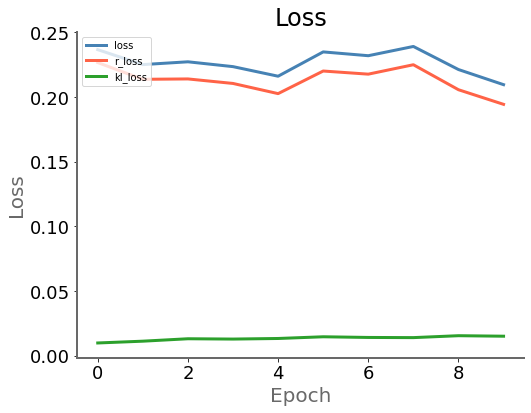

In [10]:
pwk.plot_history(history,  plot={"Loss":['loss','r_loss', 'kl_loss']}, save_as='history')

### 6.2 - Reconstruction during training
At the end of each epoch, our callback saved some reconstructed images.  
Where :  
Original image -> encoder -> z -> decoder -> Reconstructed image

<br>**Original images :**

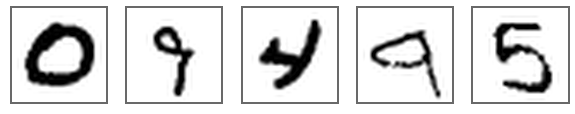

<br>**Encoded/decoded images**

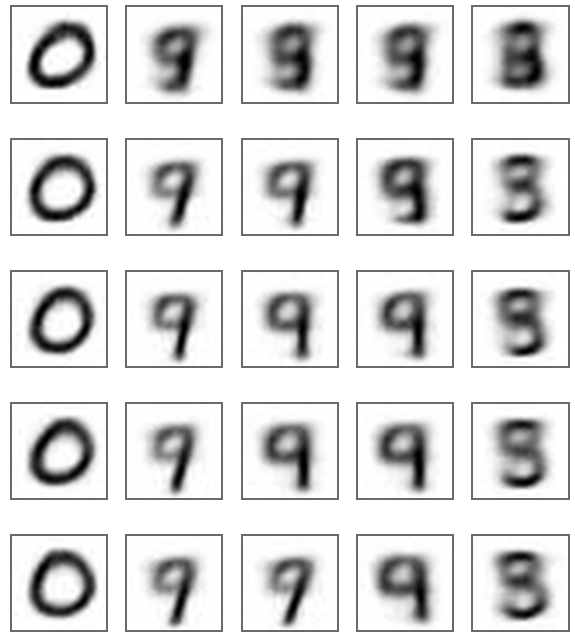

<br>**Original images :**

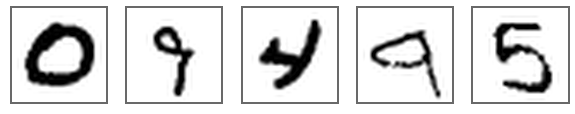

In [11]:
images_z, images_r = callback_images.get_images( range(0,epochs,2) )

pwk.subtitle('Original images :')
pwk.plot_images(x_data[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as='02-original')

pwk.subtitle('Encoded/decoded images')
pwk.plot_images(images_z, None, indices='all', columns=5, x_size=2,y_size=2, save_as='03-reconstruct')

pwk.subtitle('Original images :')
pwk.plot_images(x_data[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as=None)


### 6.3 - Generation (latent -> decoder) during training

<br>**Generated images from latent space**

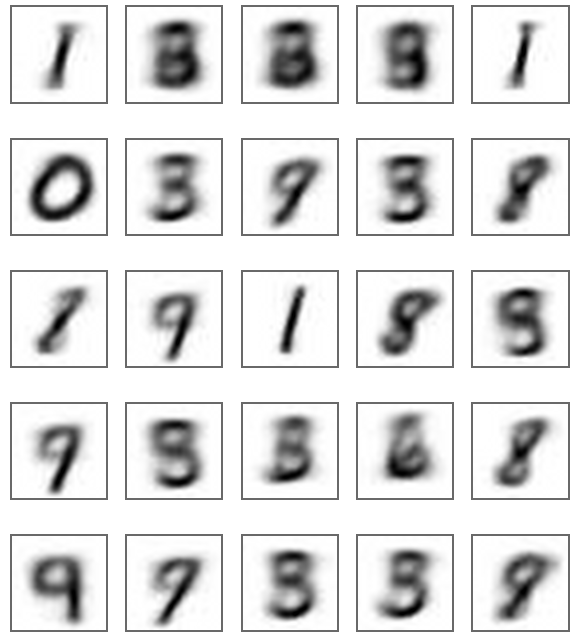

In [12]:
pwk.subtitle('Generated images from latent space')
pwk.plot_images(images_r, None, indices='all', columns=5, x_size=2,y_size=2, save_as='04-encoded')

## Step 7 - Model evaluation

### 7.1 - Reload best model

In [13]:
vae=VAE()
vae.reload(f'{run_dir}/models/best_model')

Fidle VAE is ready :-)  loss_weights=[1, 1]
Reloaded.


### 7.2 - Image reconstruction

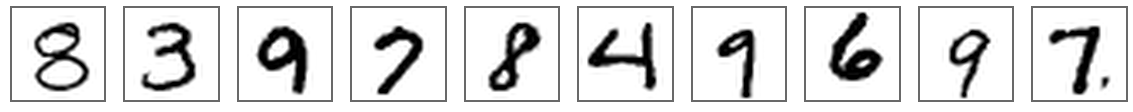

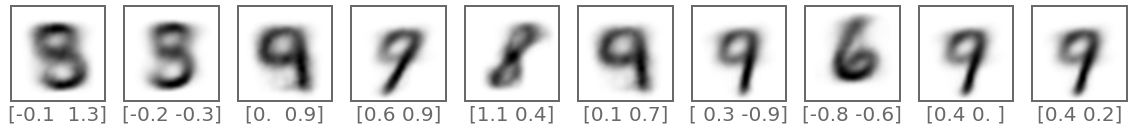

In [14]:
# ---- Select few images

x_show = pwk.pick_dataset(x_data, n=10)

# ---- Get latent points and reconstructed images

z_mean, z_var, z  = vae.encoder.predict(x_show)
x_reconst         = vae.decoder.predict(z)

# ---- Show it

labels=[ str(np.round(z[i],1)) for i in range(10) ]
pwk.plot_images(x_show,    None, indices='all', columns=10, x_size=2,y_size=2, save_as='05-original')
pwk.plot_images(x_reconst, labels  , indices='all', columns=10, x_size=2,y_size=2, save_as='06-reconstruct')


### 7.3 - Visualization of the latent space

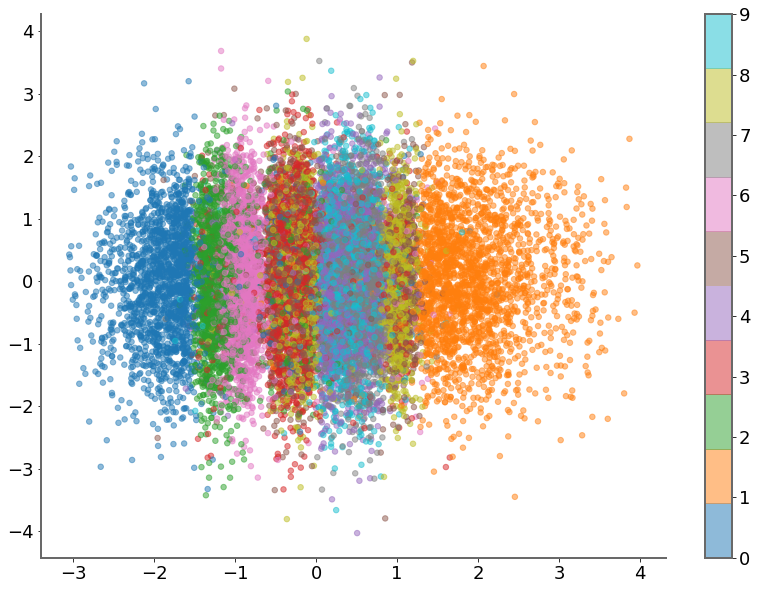

In [15]:
n_show = 20000

# ---- Select images

x_show, y_show = pwk.pick_dataset(x_data,y_data, n=n_show)

# ---- Get latent points

z_mean, z_var, z = vae.encoder.predict(x_show)

# ---- Show them

fig = plt.figure(figsize=(14, 10))
plt.scatter(z[:, 0] , z[:, 1], c=y_show, cmap= 'tab10', alpha=0.5, s=30)
plt.colorbar()
pwk.save_fig('07-Latent-space')
plt.show()

### 7.4 - Generative latent space

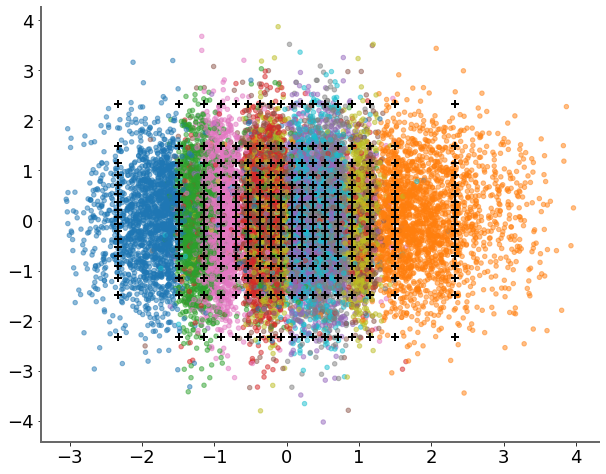

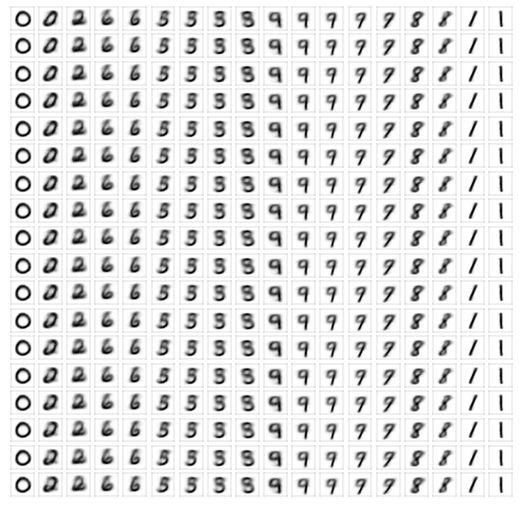

In [16]:
grid_size   = 18
grid_scale  = 1

# ---- Draw a ppf grid

grid=[]
for y in scipy.stats.norm.ppf(np.linspace(0.99, 0.01, grid_size),scale=grid_scale):
    for x in scipy.stats.norm.ppf(np.linspace(0.01, 0.99, grid_size),scale=grid_scale):
        grid.append( (x,y) )
grid=np.array(grid)

# ---- Draw latentspoints and grid

fig = plt.figure(figsize=(10, 8))
plt.scatter(z[:, 0] , z[:, 1], c=y_show, cmap= 'tab10', alpha=0.5, s=20)
plt.scatter(grid[:, 0] , grid[:, 1], c = 'black', s=60, linewidth=2, marker='+', alpha=1)
pwk.save_fig('08-Latent-grid')
plt.show()

# ---- Plot grid corresponding images

x_reconst = vae.decoder.predict([grid])
pwk.plot_images(x_reconst, indices='all', columns=grid_size, x_size=0.5,y_size=0.5, y_padding=0,spines_alpha=0.1, save_as='09-Latent-morphing')



In [17]:
pwk.end()

End time is : Monday 22 March 2021, 14:44:57
Duration is : 00:01:50 702ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>